# Trabajo Práctico 1: Propiedades en Venta

### Grupo 08

Ciriani, Chiara
Danko, Tomás
Guglielmi, Nicolás
Magnani, Elian
Shih, Ian

## Importación de Librerías

Importamos librerías generales

In [300]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Importamos librerías de modelos

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score,cross_validate

Importamos librería de métricas

In [302]:
#Metricas para evaluar modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# 1. Análisis Exploratorio y Preprocesamiento de Datos

Importamos dataset

In [303]:
dataset = pd.read_csv("properati_argentina_2021.csv")

In [304]:
dataset.shape

(460154, 20)

Filtramos los anuncios por el tipo de vivienda (Casa, PH y Departamente), ubicados en Capital Federal cuyo tipo de operacion sea venta y su precio se encuentre en dolares.

In [305]:
cond_property_types = dataset['property_type'].isin(['Casa', 'PH', 'Departamento'])
cond_operation = dataset['operation'] == 'Venta'
cond_price_currency = dataset['property_currency'] == 'USD'
cond_location = dataset['place_l2'] == 'Capital Federal'

dataset = dataset[cond_property_types & cond_operation & cond_price_currency & cond_location]

Luego, separamos en un conjunto de entrenamiento (80%) y un conjunto de test (20%)

In [306]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=2)

## a) Exploración Inicial

Listamos la cantidad de filas y columnas que tiene el dataset

In [307]:
dataset.shape

(94249, 20)

Este dataset contenía originalmente 460154 filas y 20 columnas, de las que quedaron 94249 filas y 20 columnas después del filtrado.

Listamos los nombres de las columnas del dataset

In [308]:
dataset_train.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Descripción de los campos

- id: identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.

- start_date: fecha de alta del aviso.

- end_date: fecha de baja del aviso.

- created_on: fecha de alta de la primera versión del aviso.

- latitud: latitud.

- longitud: longitud.

- place: campos referidos a la ubicación de la propiedad o del desarrollo.
	- l1 - Nivel administrativo 1: país.
	- l2 - Nivel administrativo 2: usualmente provincia.
	- l3 - Nivel administrativo 3: usualmente ciudad.
	- l4 - Nivel administrativo 4: usualmente barrio.

- operation: tipo de operación (Venta, Alquiler).

- property_type: tipo de aviso (Propiedad, Desarrollo/Proyecto).

- property_rooms: cantidad de ambientes (útil en Argentina).

- property_bedrooms: cantidad de dormitorios (útil en el resto de los países).

- property_surface_total: superficie total en m².

- property_surface_covered: superficie cubierta en m².

- property_price: precio publicado en el anuncio.

- property_currency: moneda del precio publicado.

- property_title: título del anuncio

Se decide cambiar los nombres de las columnas place_l2, place_l3 y place_l4 para lograr una mejor representación del dominio

In [309]:
columns_to_rename = {"place_l2":"city", "place_l3":"neighborhood", "place_l4":"zone"}
dataset_train.rename(columns = columns_to_rename, inplace = True)

dataset_train.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'city',
 'neighborhood',
 'zone',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Tipo de Variable

In [310]:
dataset_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
city                         object
neighborhood                 object
zone                         object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

### Variables Cuantitativas

Calcular medidas de resumen: media, mediana, q1, q3, moda.

In [311]:
dataset_train.describe()

latitud      longitud  place_l6  property_rooms  \
count  72416.000000  72416.000000       0.0    74559.000000   
mean     -34.591125    -58.450693       NaN        2.822798   
std        0.189522      0.304372       NaN        1.429959   
min      -53.788624    -71.439510       NaN        1.000000   
25%      -34.615979    -58.466523       NaN        2.000000   
50%      -34.595749    -58.439042       NaN        3.000000   
75%      -34.577395    -58.408935       NaN        4.000000   
max      -24.219827    -54.133330       NaN       40.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       66550.000000             71515.00000              72759.000000   
mean            2.015567               112.53916                 90.110213   
std             1.133740              1088.20166               1106.636675   
min            -1.000000                10.00000                  1.000000   
25%             1.000000                45.00000                 40.000000   
50%             2.000000                65.00000                 57.000000   
75%             3.000000               105.00000                 89.000000   
max            70.000000            137000.00000             217000.000000   

       property_price  
count    7.539900e+04  
mean     2.273315e+05  
std      3.256379e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.440000e+05  
75%      2.350000e+05  
max      2.140000e+07

### Variables Cualitativas

Mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [312]:
qualitative_dataset = dataset_train.select_dtypes(exclude=np.number)
new_columns = qualitative_dataset.columns.to_list()
unwanted_columns = ['id', 'start_date', 'end_date', 'created_on', 'property_title']
new_columns = [e for e in new_columns if e not in unwanted_columns]

for column in new_columns:
    print(column)
    print(f"Cantidad de valores posibles: {qualitative_dataset[column].nunique()}")
    print(qualitative_dataset[column].value_counts())
    print()


city
Cantidad de valores posibles: 1
Capital Federal    75399
Name: city, dtype: int64

neighborhood
Cantidad de valores posibles: 57
Palermo                 11517
Belgrano                 7092
Caballito                5727
Recoleta                 4992
Villa Urquiza            3759
Almagro                  3279
Nuñez                    2791
Villa Crespo             2518
Flores                   2500
Barrio Norte             2367
Balvanera                2046
Colegiales               1564
Villa Devoto             1544
Villa del Parque         1490
Saavedra                 1470
Puerto Madero            1210
San Telmo                1086
San Cristobal            1050
Barracas                 1010
San Nicolás              1008
Retiro                   1001
Boedo                     981
Floresta                  951
Monserrat                 899
Parque Chacabuco          840
Villa Pueyrredón          803
Coghlan                   792
Villa Luro                577
Chacarita                 

### Variables Irrelevantes

A partir del análisis se decide eliminar los campos de IDs (ya que se percibe irrelevante para el tratamiento que se está haciendo de los datos), Property Currency (porque luego del filtrado solo se listarán propiedades en USDs), City (debido a que post filtrado solo quedan propiedades de Capital Federal) y Operation (solo hay propiedades en venta).

In [313]:
ds_cropped = dataset_train.drop(['id', 'property_currency', 'city', 'operation'], axis='columns')
ds_cropped.columns.tolist()

['start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'neighborhood',
 'zone',
 'place_l5',
 'place_l6',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_title']

### Análisis gráfico de las distribuciones de las variables

En esta parte se realizan gráficos para analizar las distribuciones de las variables. Se graficarán por separado las variables cualitativas (discretas) y cuantitativas (continuas). Asimismo, se dejaran afuera ciertas variables como las coordenadas, fechas y titulos debido a que no aportan información en este análisis.

Al visualizar los gráficos se pueden observar ciertos detalles como por ejemplo la presencia de outliers y tendencias.

Variables Discretas

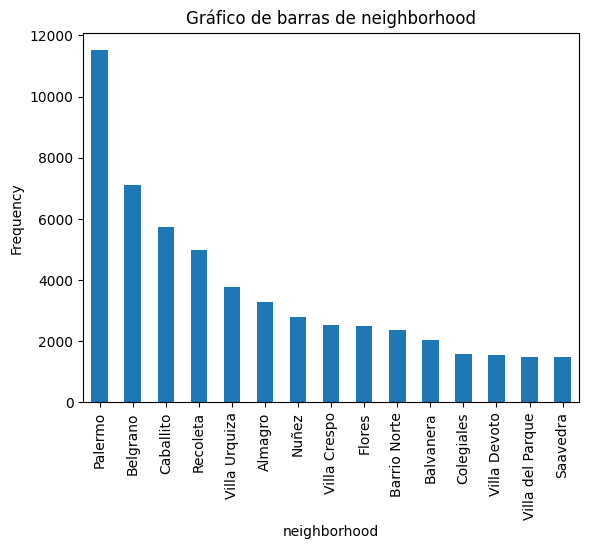

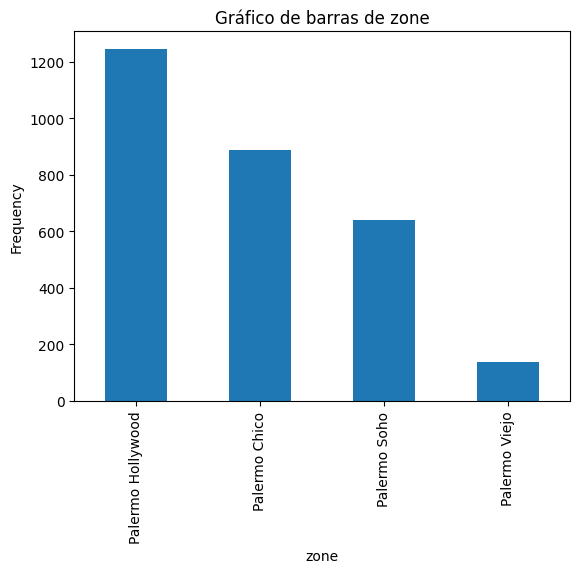

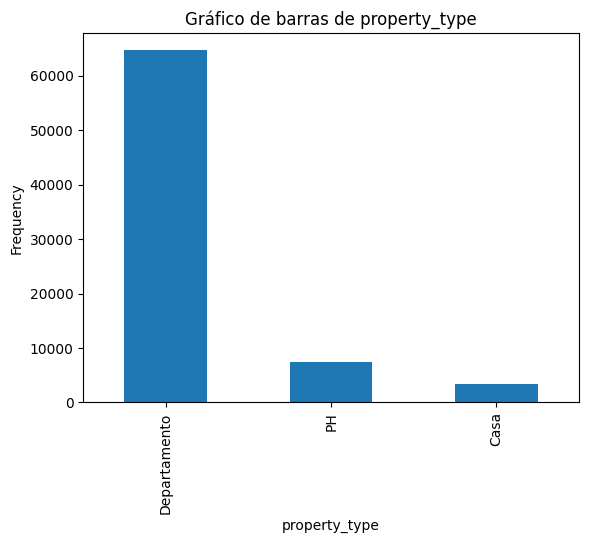

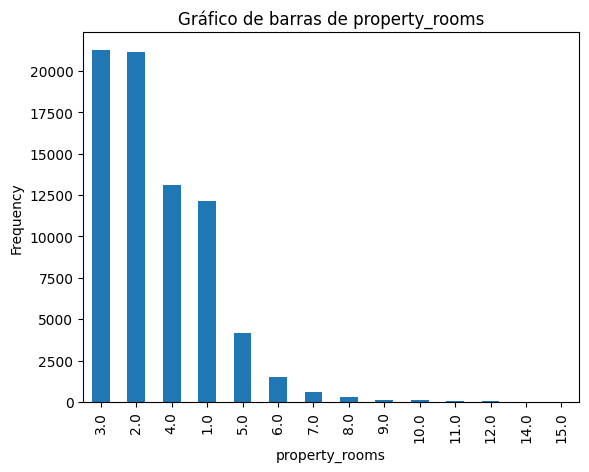

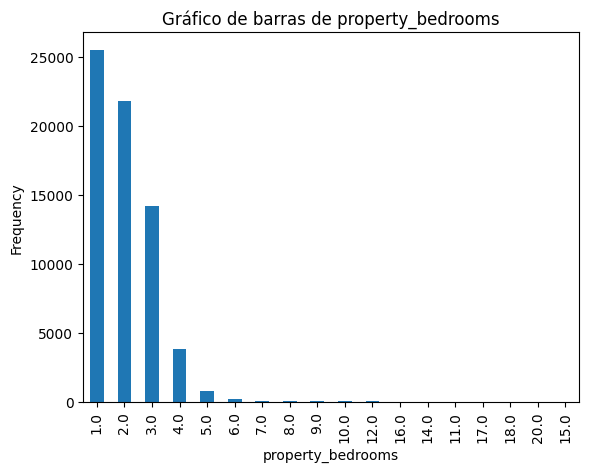

In [314]:
wanted_discreet_variables = ['neighborhood', 'zone', 'property_type', 'property_rooms', 'property_bedrooms']
plt.style.use("default")
for variable in wanted_discreet_variables:
    title = f"Gráfico de barras de " + variable
    counted_values = ds_cropped[variable].value_counts()
    if len(counted_values) > 15:
        counted_values[:15].plot.bar(title=title, xlabel=variable,ylabel="Frequency")
    else:
        counted_values.plot.bar(title=title, xlabel=variable,ylabel="Frequency")
    plt.show()


Variables Continuas

[Text(0.5, 1.0, 'latitud density'),
 Text(0.5, 0, 'latitud'),
 Text(0, 0.5, 'Density')]

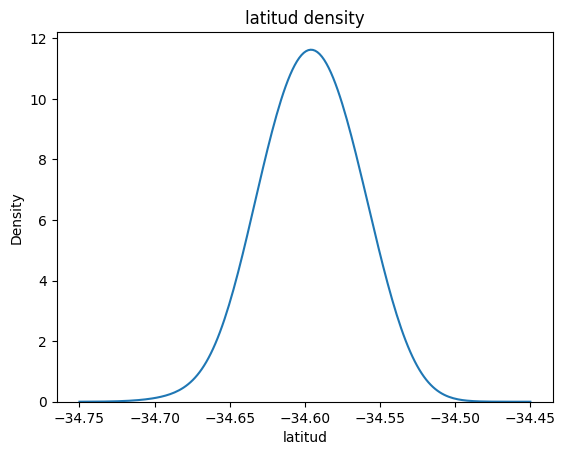

In [315]:
variable = 'latitud'
sns.kdeplot(data=ds_cropped[variable], fill=False, clip=(-34.75, -34.45)).set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'longitud density'),
 Text(0.5, 0, 'longitud'),
 Text(0, 0.5, 'Density')]

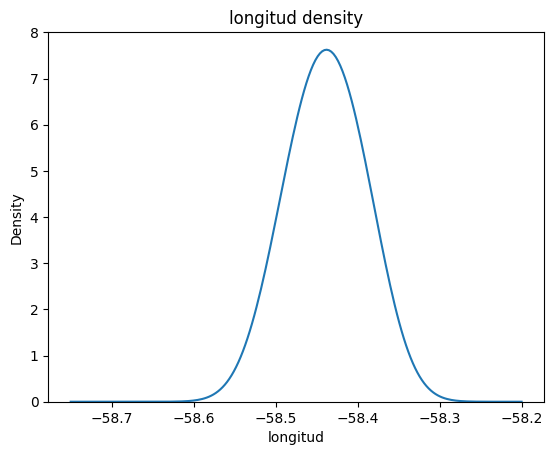

In [316]:
variable = 'longitud'
sns.kdeplot(data=ds_cropped[variable], fill=False, clip=(-58.75, -58.2)).set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'property_price density'),
 Text(0.5, 0, 'property_price'),
 Text(0, 0.5, 'Density')]

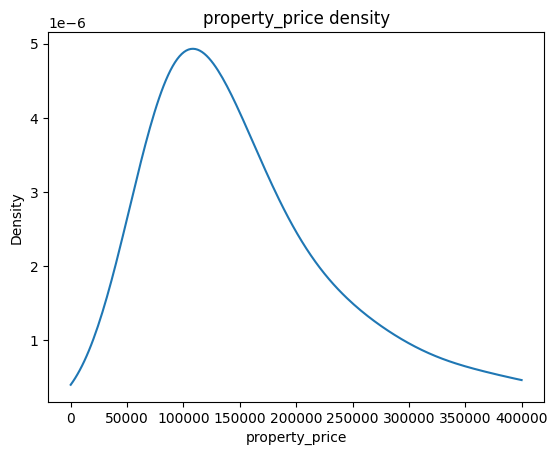

In [317]:
variable = 'property_price'
sns.kdeplot(data=ds_cropped[variable], fill=False, clip=(0, 400000)).set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'property_surface_total density'),
 Text(0.5, 0, 'property_surface_total'),
 Text(0, 0.5, 'Density')]

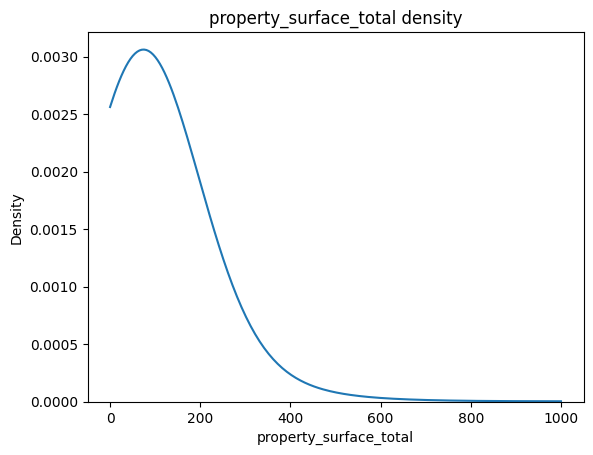

In [318]:
variable = 'property_surface_total'
sns.kdeplot(data=ds_cropped[variable], fill=False, clip=(0, 1000)).set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'property_surface_covered density'),
 Text(0.5, 0, 'property_surface_covered'),
 Text(0, 0.5, 'Density')]

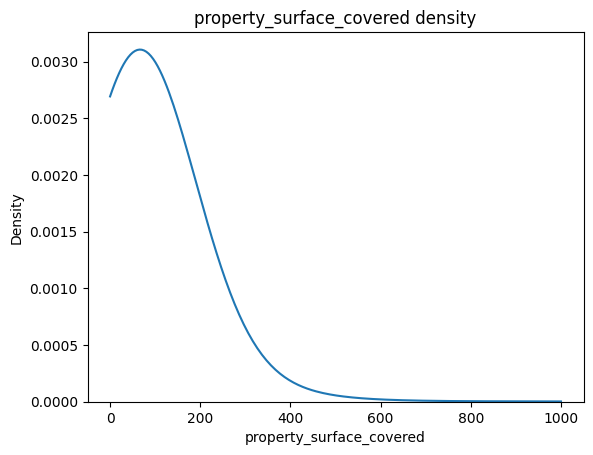

In [319]:
variable = 'property_surface_covered'
sns.kdeplot(data=ds_cropped[variable], fill=False, clip=(0, 1000)).set(title=f"{variable} density", xlabel=variable, ylabel="Density")

### Correlaciones existentes entre variables

Para analizar la correlación entre variables procedemos a realizar un heatmap usando el método de correlación de Pearson (mide su correlación lineal con el coeficiente de correlación r) que mientras más cerca de 1, indica mayor correlación lineal positiva, y mientras más cerca de -1 mayor correlación lineal negativa.

Es importante para este análisis elegir un método de conversión de variables categóricas para que puedan ser medidas con el resto. Para este caso, nosotros elegimos One Hot Encoding y dejamos de lado las variables "barrio" y "zona" ya que al tener 57 y 4 valores posibles respectivamente, el heatmap pierde legibilidad.

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_17640\465094372.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_dummies.corr(method='pearson'), annot=True, cmap="YlGnBu")


<AxesSubplot:>

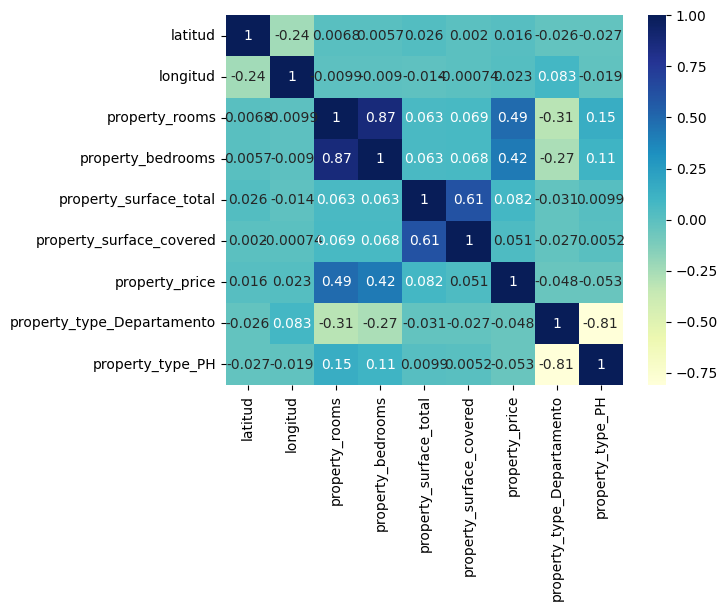

In [320]:
df_dummies = pd.get_dummies(ds_cropped, columns=['property_type'], drop_first=True).drop("place_l6", axis=1)
sns.heatmap(df_dummies.corr(method='pearson'), annot=True, cmap="YlGnBu")

## Conclusiones de la Exploración Inicial

Este primer acercamiento al entendimiento del set de datos con el cual se está trabajando ha sido de vital importancia para tomar ciertas decisiones que agilizan el procesamiento del gran volumen de información que se dispone. Ha de notarse que gracias a esto, se pudo purgar el dataset de todo aquello que se considera irrelevante para nuestro objetivo y se ha podido comprender mucho mejor las características del mismo (ya sea el tipo de variables que intervienen como también lo que representa cada una).

De ahora en adelante se pretende seguir trabajando con los datos purificados de manera un poco mas clara y efectiva.

## b) Datos Faltantes

Si bien no se pide, es útil analizar los datos duplicados ya que dependiendo del dataset, a veces tenemos información duplicada que no queremos. Luego, si alertamos una fila duplicada, la eliminamos. Esto lo podemos hacer gracias a que contamos con las columnas "latitud" y "longitud". Si se detecta que dos propiedades no solo tienen todas sus características iguales si no también idénticas coordenadas, entonces consideramos que es una propiedad duplicada.

In [321]:
size_antes = len(ds_cropped)
ds_cropped = ds_cropped.drop_duplicates()
size_despues = len(ds_cropped)
print(f'Se eliminaron: {size_antes-size_despues} filas duplicadas')

Se eliminaron: 819 filas duplicadas


Los valores nulos pueden tener distintas formas de ser representados:

- Nan

- Vacíos ""

- Algún caracter especial "_", "?", "NULL"

- Valores que no tienen sentido dado la variable (ejemplo: distancia recorrida: -1)

Vamos a analizar el dataset general

In [322]:
tienen_caracter_raro = ds_cropped.astype('str').eq('-').any(0)
tienen_caracter_raro

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_17640\4116890165.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tienen_caracter_raro = ds_cropped.astype('str').eq('-').any(0)


start_date                  False
end_date                    False
created_on                  False
latitud                     False
longitud                    False
neighborhood                False
zone                        False
place_l5                    False
place_l6                    False
property_type               False
property_rooms              False
property_bedrooms           False
property_surface_total      False
property_surface_covered    False
property_price              False
property_title              False
dtype: bool

Chequemos variables numéricas

In [323]:
quantitative_dataset = ds_cropped.select_dtypes(include=np.number)
quantitative_columns = quantitative_dataset.columns
(dataset[quantitative_columns] <= 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
latitud                            True
longitud                           True
place_l6                          False
property_rooms                    False
property_bedrooms                  True
property_surface_total            False
property_surface_covered          False
property_price                    False

Mientras que las variables 'latitud' y ' longitud' tienen sentido que sean menores a 0, no es el caso de la variable 'property_bedrooms' ya que no se puede tener habitaciones negativas en una propiedad. Después exploraremos opciones para manejar este caso sin sentido.

Revisamos si las variables numéricas son decimales:

In [324]:
quantitative_dataset = ds_cropped.select_dtypes(include=np.float)
quantitative_columns = quantitative_dataset.columns
(dataset[quantitative_columns]).any().to_frame('Variables decimales ?')

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_17640\56666754.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  quantitative_dataset = ds_cropped.select_dtypes(include=np.float)


Variables decimales ?
latitud                                    True
longitud                                   True
place_l6                                  False
property_rooms                             True
property_bedrooms                          True
property_surface_total                     True
property_surface_covered                   True
property_price                             True

Tienen sentido que esas variables sean decimales salvo por las variables 'property_rooms' y 'property_bedrooms' ya que no se puede tener, por ejemplo, 2.5 habitaciones en una propiedad. Esto puede ser debido a un error de tipeo, como por ejemplo eran 5 habitaciones y se tipeó 0.5 o directamente es un error. Después exploraremos opciones para manejar este caso sin sentido.

Porcentaje de datos nulos por columna

In [325]:
print(ds_cropped.isna().sum()/len(ds_cropped)*100)

start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.907214
longitud                      3.907214
neighborhood                  0.457227
zone                         96.141057
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.107536
property_bedrooms            11.680075
property_surface_total        5.143470
property_surface_covered      3.506302
property_price                0.000000
property_title                0.000000
dtype: float64


<AxesSubplot:>

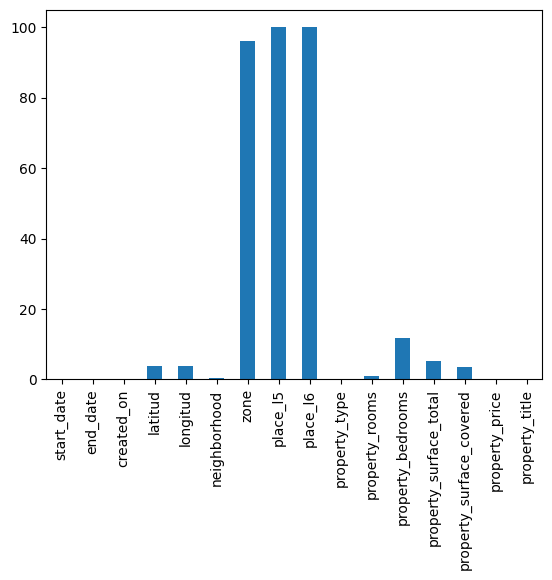

In [326]:
missing_data_series_by_column = ds_cropped.isna().sum()/len(ds_cropped) * 100
missing_data_series_by_column.plot.bar(x='columnas', y='porcentaje de datos faltantes')

In [327]:
# comento esto porque tarda mucho

#missing_data_series_by_row = (ds_cropped.isna().sum(axis = 1) / ds_cropped.shape[1] * 100).reset_index(drop = True)
#missing_data_series_by_row.plot.bar(x='filas', y='porcentaje de datos faltantes')

### Estrategias para reparar los valores faltantes

Una vez analizados los datos, tenemos que tomar desiciones sobre qué hacer con los datos faltantes

Opción 0: Eliminarlos del dataset

In [328]:
dataset_eliminar_nans=ds_cropped.copy()

columnas_eliminar_NANs=['neighborhood']
dataset_eliminar_nans.drop(columnas_eliminar_NANs, axis='columns', inplace=True)

filas_totales=dataset_eliminar_nans.shape[0]
print(dataset_eliminar_nans.isna().sum()/filas_totales*100)

start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.907214
longitud                      3.907214
zone                         96.141057
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.107536
property_bedrooms            11.680075
property_surface_total        5.143470
property_surface_covered      3.506302
property_price                0.000000
property_title                0.000000
dtype: float64


Eliminamos el resto de las filas con Nans

In [329]:
dataset_eliminar_nans.dropna(inplace=True)

print(f"cantidad de registros originales: {ds_cropped.shape[0]}")
print(f"cantidad de registros finals: {dataset_eliminar_nans.shape[0]}")

porcentaje=(ds_cropped.shape[0]-dataset_eliminar_nans.shape[0])/ds_cropped.shape[0]*100

print(f"Eliminamos el {porcentaje}% de los registros")

cantidad de registros originales: 74580
cantidad de registros finals: 0
Eliminamos el 100.0% de los registros


Opción 1: Tratarla como una "categoría" o valor más

En este caso, tratamos como si valor None fuese categoría nueva, es decir, cambiamos por constante

In [330]:
dataset_eliminar_nans_op1=ds_cropped.copy()

Por ejemplo, asignamos a las filas en las que falta el atributo 'property_bedrooms' el valor 99 

In [331]:
dataset_eliminar_nans_op1['property_bedrooms'] = dataset_eliminar_nans_op1['property_bedrooms'].fillna(99)

Otro ejemplo es a lo que les falta el atributo 'neighborhood' le ponemos a todos  'Ciudad no existe'

In [332]:
dataset_eliminar_nans_op1['neighborhood'] = dataset_eliminar_nans_op1['neighborhood'].fillna("Ciudad no existe")

Opción 2: completar usando info de esa columna (Univariadas)

La idea es completar con la mediana, promedio, moda o constante

In [333]:
dataset_eliminar_nans_op2=ds_cropped.copy()

In [334]:
# Devuelve el valor de imputacion de las tres estrategias para esa columna

def show_strategies(df, name_col, k=99):
    _df = df[[name_col]].copy()
    s = df[name_col]

    _df['mediana'] = s.fillna(s.median())
    _df['media'] = s.fillna(s.mean())
    _df['moda'] = s.fillna(s.mode()[0])
    _df['constante'] = k

    return _df[s.isna()]

show_strategies(dataset_eliminar_nans_op2, 'property_bedrooms',99)

property_bedrooms  mediana     media  moda  constante
27438                 NaN      2.0  2.016427   1.0         99
155007                NaN      2.0  2.016427   1.0         99
163967                NaN      2.0  2.016427   1.0         99
310141                NaN      2.0  2.016427   1.0         99
137226                NaN      2.0  2.016427   1.0         99
...                   ...      ...       ...   ...        ...
373821                NaN      2.0  2.016427   1.0         99
298297                NaN      2.0  2.016427   1.0         99
255850                NaN      2.0  2.016427   1.0         99
212476                NaN      2.0  2.016427   1.0         99
264371                NaN      2.0  2.016427   1.0         99

[8711 rows x 5 columns]

Opción 3: completar usando info de las demas columnas (Multivariada)

In [335]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_bedrooms']
dataset_eliminar_nans_op3=ds_cropped[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0) #imputation_order='roman'
dataset_eliminar_nans_op3_completo=imp.fit_transform(dataset_eliminar_nans_op3)

In [336]:
dataset_eliminar_nans_op3_completo

array([[ 65.        ,  53.        ,   1.        ],
       [ 29.        ,  29.        ,   2.00883219],
       [ 41.        ,  35.        ,   1.        ],
       ...,
       [ 52.        ,  45.        ,   1.        ],
       [123.        ,  71.        ,   2.        ],
       [ 50.        ,  10.74199592,   1.        ]])

Existen otras opciones que no haremos pero valen la pena mencionar:

Opción 4: Imputación Cold Deck
Selecciona valores o usa relaciones obtenidas de fuentes distintas de la base de datos actual

Opción 5: Imputación Hot Deck
Se reemplazan los faltantes con valores obtenidos de registros que son los más similares.

Opción 6: Imputación por regresión
El dato faltante es reemplazado con el valor predicho por un modelo de regresión

Opción 7: MICE - Multivariate Imputation by Chained Equations
Trabaja bajo el supuesto de que el origen de los faltantes es Missing At Random (MAR).
Es un proceso de imputación de datos faltantes iterativo, en el cual, en cada iteración cada valor faltante de cada variable se predice en función de las variables restantes.
Esta iteración se repite hasta que se encuentre convergencia en los valores.
Por lo general 10 iteraciones es suficiente.
(En cada iteración genera un dataset)

Una vez analizadas todas las opciones, procedemos a eliminar los valores faltantes:

Debido a que las columnas 'place_l5' y 'place_l6' tienen el 100% de datos nulos, creemos que es mejor directamente eliminar ambas columnas. Si bien 'zone' no tiene el 100%, creemos que 96% es un porcentaje bastante alto y también la vamos a eliminar.

In [337]:
ds_cropped_without_nans=ds_cropped.copy()

columnas_eliminar_NANs=['zone','place_l5','place_l6']
ds_cropped_without_nans.drop(columnas_eliminar_NANs, axis='columns', inplace=True)

ds_cropped_without_nans_without_imputations=ds_cropped_without_nans.copy()

filas_totales=ds_cropped_without_nans.shape[0]
print(ds_cropped_without_nans.isna().sum()/filas_totales*100)

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      3.907214
longitud                     3.907214
neighborhood                 0.457227
property_type                0.000000
property_rooms               1.107536
property_bedrooms           11.680075
property_surface_total       5.143470
property_surface_covered     3.506302
property_price               0.000000
property_title               0.000000
dtype: float64


Todavía quedan columnas con porcentaje de datos nulos. Para los valores nulos restantes se reemplazará por la media. Pero al ser "property_rooms" y "property_bedrooms" categorías con valores que deben ser enteros, optamos por eliminar aquellas filas con valores nulos en estas categorías.

In [338]:
ds_cropped_without_nans.dropna(inplace = True, subset = ['property_rooms', 'property_bedrooms'])

In [339]:
ds_cropped_without_nans = ds_cropped_without_nans.fillna(ds_cropped_without_nans.mean())

filas_totales=ds_cropped_without_nans.shape[0]
print((ds_cropped_without_nans.isna().sum()/filas_totales)*100)

start_date                  0.00000
end_date                    0.00000
created_on                  0.00000
latitud                     0.00000
longitud                    0.00000
neighborhood                0.26154
property_type               0.00000
property_rooms              0.00000
property_bedrooms           0.00000
property_surface_total      0.00000
property_surface_covered    0.00000
property_price              0.00000
property_title              0.00000
dtype: float64


C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_17640\3096266794.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_cropped_without_nans = ds_cropped_without_nans.fillna(ds_cropped_without_nans.mean())


In [340]:
print(ds_cropped_without_nans["neighborhood"].isna().sum())

171


Podemos observar que para este entonces, la única categoría que todavía posee valores faltantes es la de neighborhood. Esto se debe a que es una categoría con valores cualitativos, que no pueden ser imputados utilizando la media. Para este caso en particular usaremos la técnica Cold Deck que utiliza una fuente de información extra que contiene la representación geográfica de la ciudad y evaluamos a que barrio pertenece cada inmueble que no tenga informado este dato. Para esto, lo más lógico es usar los valores de latitud y longitud que nos ayudarán a determinar a qué neighbourhood pertenece.

In [341]:
from shapely.geometry import MultiPolygon, Point
#import geopandas as gpd
from shapely import wkt

import csv

barrios_reader = csv.reader("barrios.csv", delimiter=";")
barrios_dict = {}

with open('barrios.csv', newline='') as csvfile:
    barrios_reader = csv.reader(csvfile, delimiter=';')
    next(barrios_reader)
    for row in barrios_reader:
        barrios_dict[row[1]] = wkt.loads(row[0])

def determinar_barrio(propiedad):
    for barrio in barrios_dict:
        if barrios_dict[barrio].contains(Point(propiedad["longitud"], propiedad["latitud"])):
            return barrio

barrios_nuevos = [determinar_barrio(propiedad) for index, propiedad in ds_cropped_without_nans[ds_cropped_without_nans['neighborhood'].isna()].iterrows()]
barrios_nuevos_to_replace = {k: v for k, v in enumerate(barrios_nuevos) if v != None}
print(len(barrios_nuevos_to_replace))
ds_cropped_without_nans['neighborhood'].fillna(value=barrios_nuevos_to_replace, inplace=True, axis='index')

#print(ds_cropped_without_nans.isna().sum()/filas_totales*100)

60


In [342]:
print((ds_cropped_without_nans.isna().sum()/filas_totales)*100)

start_date                  0.00000
end_date                    0.00000
created_on                  0.00000
latitud                     0.00000
longitud                    0.00000
neighborhood                0.26001
property_type               0.00000
property_rooms              0.00000
property_bedrooms           0.00000
property_surface_total      0.00000
property_surface_covered    0.00000
property_price              0.00000
property_title              0.00000
dtype: float64


Realizo los mismos cambios hechos en el dataset de training para el dataset de test:

In [343]:
dataset_test.rename(columns = columns_to_rename, inplace = True)
dataset_test.drop(['id', 'property_currency', 'city', 'operation'], axis='columns')
dataset_test = dataset_test.drop_duplicates()
dataset_test.drop(columnas_eliminar_NANs, axis='columns', inplace=True)
dataset_test = dataset_test.fillna(dataset_test.mean())

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_17640\2344353561.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_test = dataset_test.fillna(dataset_test.mean())


Se realizaron imputaciones para las siguientes categorías:

- latitud

- longitud

- property_surface_total

- property_surface_covered

- neighborhood

Azul: Dataset con imputaciones

Naranja: Dataset sin imputaciones

[Text(0.5, 1.0, 'latitud density'),
 Text(0.5, 0, 'latitud'),
 Text(0, 0.5, 'Density')]

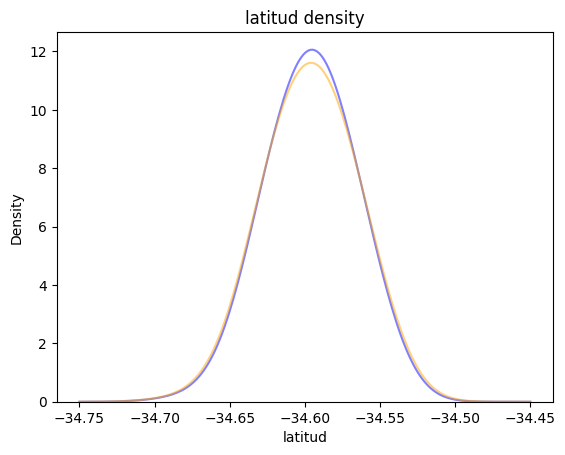

In [344]:
variable = 'latitud'
sns.kdeplot(data=ds_cropped_without_nans[variable], fill=False, alpha=0.5, clip=(-34.75, -34.45), color='blue').set(title=f"{variable} density", xlabel=variable, ylabel="Density")
sns.kdeplot(data=ds_cropped_without_nans_without_imputations[variable], fill=False, alpha=0.5, clip=(-34.75, -34.45), color='orange').set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'longitud density'),
 Text(0.5, 0, 'longitud'),
 Text(0, 0.5, 'Density')]

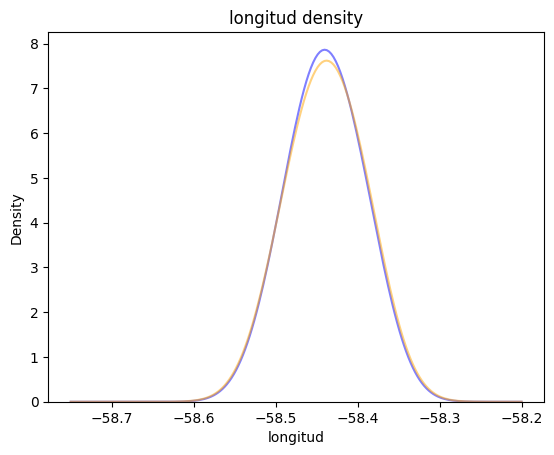

In [345]:
variable = 'longitud'
sns.kdeplot(data=ds_cropped_without_nans[variable], fill=False, alpha=0.5, clip=(-58.75, -58.2), color='blue').set(title=f"{variable} density", xlabel=variable, ylabel="Density")
sns.kdeplot(data=ds_cropped_without_nans_without_imputations[variable], fill=False, alpha=0.5, clip=(-58.75, -58.2), color='orange').set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'property_surface_total density'),
 Text(0.5, 0, 'property_surface_total'),
 Text(0, 0.5, 'Density')]

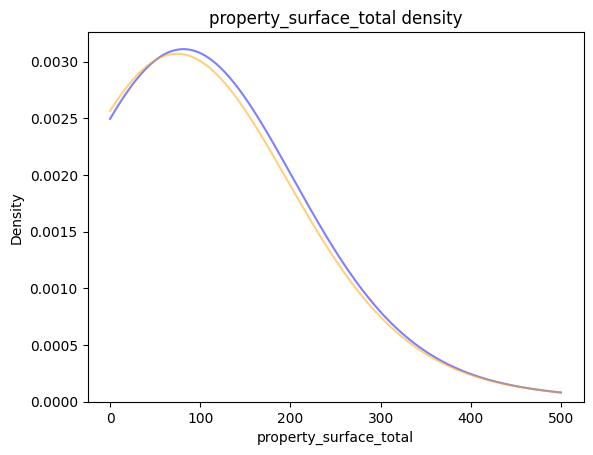

In [346]:
variable = 'property_surface_total'
sns.kdeplot(data=ds_cropped_without_nans[variable], fill=False, alpha=0.5, clip=(0, 500), color='blue').set(title=f"{variable} density", xlabel=variable, ylabel="Density")
sns.kdeplot(data=ds_cropped_without_nans_without_imputations[variable], fill=False, alpha=0.5, clip=(0, 500), color='orange').set(title=f"{variable} density", xlabel=variable, ylabel="Density")

[Text(0.5, 1.0, 'property_surface_covered density'),
 Text(0.5, 0, 'property_surface_covered'),
 Text(0, 0.5, 'Density')]

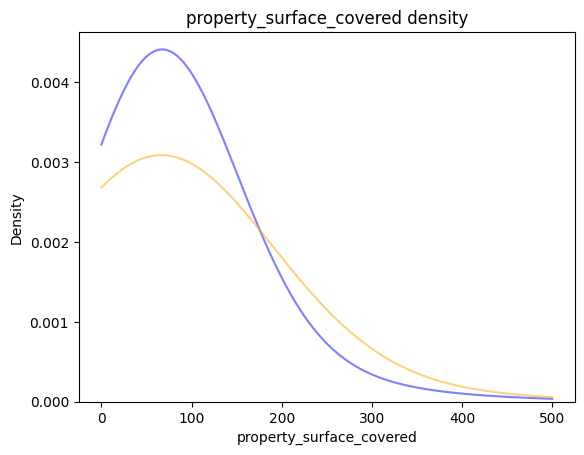

In [347]:
variable = 'property_surface_covered'
sns.kdeplot(data=ds_cropped_without_nans[variable], fill=False, alpha=0.5, clip=(0, 500), color='blue').set(title=f"{variable} density", xlabel=variable, ylabel="Density")
sns.kdeplot(data=ds_cropped_without_nans_without_imputations[variable], fill=False, alpha=0.5, clip=(0, 500), color='orange').set(title=f"{variable} density", xlabel=variable, ylabel="Density")

<AxesSubplot:title={'center':'Gráfico de barras de neighborhood'}, xlabel='neighborhood', ylabel='Frequency'>

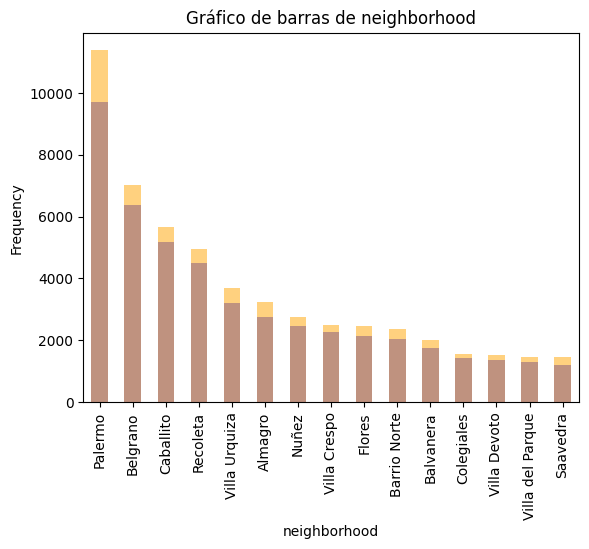

In [348]:
variable = 'neighborhood'
title = f"Gráfico de barras de " + variable

counted_values = ds_cropped_without_nans[variable].value_counts()
counted_values[:15].plot.bar(color='blue', title=title, xlabel=variable,ylabel="Frequency", alpha=0.5)

counted_values = ds_cropped_without_nans_without_imputations[variable].value_counts()
counted_values[:15].plot.bar(color='orange', title=title, xlabel=variable,ylabel="Frequency", alpha=0.5)

## c) Valores Atípicos

### Análisis univariado

Mediante el análisis de los gráficos de tipo Box-Plot vamos a intentar identificar outliers univariados.

1. Variable 'property_rooms'

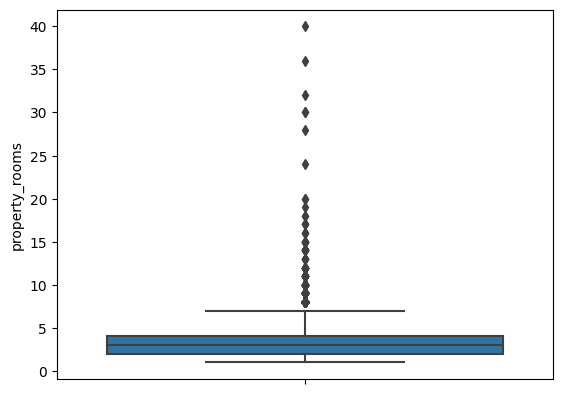

In [349]:
sns.boxplot(y=ds_cropped_without_nans.property_rooms)
plt.show()

In [350]:
#Cuartiles
Q1_property_rooms=np.quantile(ds_cropped_without_nans.property_rooms,0.25)
Q3_property_rooms=np.quantile(ds_cropped_without_nans.property_rooms,0.75)

#Rango intercuartil
IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

#Limite inferior Outliers
out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print(out_inf)
print(out_sup)

-1.0
7.0


Encontramos que existen outliers univariados en la variable 'property_rooms'. Verificamos que no se trata de un valor posible y procedemos a eliminarlo. En este caso, consideramos que es extraño que una propiedad contenga más de 7 habitaciones.

In [351]:
#Observación anómala
ds_cropped_without_nans_and_anomalies = ds_cropped_without_nans.copy()
outliers=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_rooms']>7]
outliers

start_date    end_date  created_on    latitud   longitud  \
362676  2021-01-16  2021-08-06  2021-01-16 -34.618485 -58.377993   
358714  2021-06-29  2021-08-10  2021-06-29 -34.590923 -58.384214   
338930  2021-06-01  2021-06-05  2021-06-01 -34.565930 -58.483281   
391896  2021-10-28  9999-12-31  2021-10-28 -34.538492 -58.467574   
173300  2021-05-11  2021-09-16  2021-05-11 -34.631117 -58.382757   
...            ...         ...         ...        ...        ...   
21458   2021-10-01  2022-02-09  2021-10-01 -34.546268 -58.459154   
88590   2021-05-14  2021-08-06  2021-05-14 -34.552565 -58.479308   
203282  2021-05-10  2021-06-05  2021-05-10 -34.569861 -58.444716   
70107   2021-09-23  2022-01-27  2021-09-23 -34.588758 -58.388796   
395051  2021-02-13  2021-03-01  2021-02-13 -34.622091 -58.508864   

         neighborhood property_type  property_rooms  property_bedrooms  \
362676      San Telmo          Casa            16.0               16.0   
358714       Recoleta  Departamento             9.0                4.0   
338930  Villa Urquiza          Casa            10.0                4.0   
391896          Nuñez          Casa             8.0                4.0   
173300   Constitución          Casa            14.0               12.0   
...               ...           ...             ...                ...   
21458           Nuñez            PH             8.0                7.0   
88590        Saavedra          Casa             8.0                4.0   
203282       Belgrano            PH            12.0                9.0   
70107        Recoleta  Departamento            10.0                5.0   
395051   Monte Castro          Casa             8.0                6.0   

        property_surface_total  property_surface_covered  property_price  \
362676              114.949644                     943.0       1300000.0   
358714              668.000000                     668.0       5000000.0   
338930              294.000000                     279.0        550000.0   
391896              114.949644                     350.0        990000.0   
173300              466.000000                     436.0        390000.0   
...                        ...                       ...             ...   
21458               246.000000                     172.0        370000.0   
88590               353.000000                     328.0        680000.0   
203282              711.000000                     711.0        525000.0   
70107               477.000000                     400.0       1800000.0   
395051              360.000000                     282.0        420000.0   

                                           property_title  
362676                                  Casa en San Telmo  
358714  VENTA impresionante PISO muy ALTO 668,62 m2 co...  
338930                               Casa - Villa Urquiza  
391896  Casa - Lomas de Nuñez - Sobre dos lotes - Jard...  
173300  CASA EN VENTA 14 AMB.  CONSTITUCIÓN PATIO TERRAZA  
...                                                   ...  
21458       VENTA.  3 PH + LOCAL COMERCIAL EN NUÑEZ, CABA  
88590   EXCELENTE  CASA EN VENTA EN EL BARRIO DE SAAVEDRA  
203282                          Av. Federico Lacroze 2400  
70107                             Departamento - Recoleta  
395051         Venta Casa 8 ambientes con garaje y Jardin  

[565 rows x 13 columns]

In [352]:
#Eliminación de outlier por índice de fila
indice_outlier=outliers.index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Visualicemos nuevamente el Box-Plot

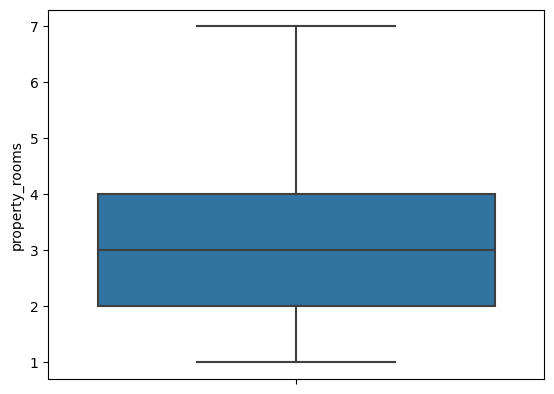

In [353]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_rooms)
plt.show()

DUDAAAAA: DEBERÍAMOS CONSIDERAR TODO LO QUE SEA MAYOR A 7.5 OUTLIER? OSEA SI ES UNA MANSION ES NORMAL CAPAZ QUE TENGA 15 NI IDEA NO TENGO UNA MANSION

ALSO TO DO: validar en valores faltatntes de sacar las property_rooms y property_bedrooms de sacar los decimales porque no tiene sentido tener mitad habitación

2. Variable 'property_bedrooms'

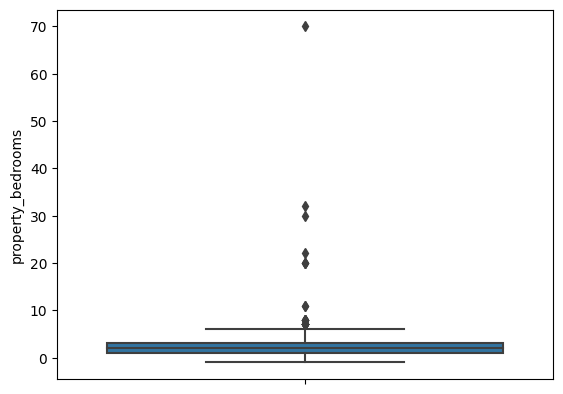

In [354]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_bedrooms)
plt.show()

In [355]:
#Cuartiles
Q1_property_bedrooms=np.quantile(ds_cropped_without_nans_and_anomalies.property_bedrooms,0.25)
Q3_property_bedrooms=np.quantile(ds_cropped_without_nans_and_anomalies.property_bedrooms,0.75)

#Rango intercuartil
IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

#Limite inferior Outliers
out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print(out_inf)
print(out_sup)

-2.0
6.0


Encontramos que existen outliers univariados en la variable 'property_bedrooms'. Verificamos que no se trata de un valor posible y procedemos a eliminarlo. En este caso, consideramos que es extraño que una propiedad contenga más de 10 dormitorios.

In [356]:
outliers=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_bedrooms']>10]
outliers

start_date    end_date  created_on    latitud   longitud  \
36421   2021-09-21  2022-02-03  2021-09-21 -34.576061 -58.421289   
337147  2021-04-13  2021-06-05  2021-04-13 -34.592497 -58.449517   
97734   2021-11-25  2022-01-27  2021-11-25 -34.598309 -58.379852   
94998   2021-09-24  2022-01-27  2021-09-24 -34.646632 -58.497902   
41088   2021-07-19  9999-12-31  2021-07-19 -34.614573 -58.480650   
48279   2021-03-14  2021-06-05  2021-03-14 -34.608645 -58.485619   
337831  2021-04-13  2021-06-05  2021-04-13 -34.592497 -58.449517   
86014   2021-03-26  2021-06-05  2021-03-26 -34.591110 -58.400685   
140832  2021-12-08  2022-01-27  2021-12-08 -34.588454 -58.385257   

            neighborhood property_type  property_rooms  property_bedrooms  \
36421            Palermo  Departamento             3.0               20.0   
337147           Almagro  Departamento             3.0               20.0   
97734             Retiro  Departamento             1.0               11.0   
94998         Villa Luro  Departamento             3.0               70.0   
41088   Villa del Parque  Departamento             2.0               11.0   
48279   Villa del Parque  Departamento             4.0               32.0   
337831         Caballito  Departamento             3.0               20.0   
86014           Recoleta  Departamento             4.0               30.0   
140832          Recoleta  Departamento             5.0               22.0   

        property_surface_total  property_surface_covered  property_price  \
36421               127.000000                     117.0        650000.0   
337147              111.000000                      76.0        245000.0   
97734                22.000000                      20.0         62000.0   
94998               114.949644                      70.0        135000.0   
41088                14.000000                      35.0         95000.0   
48279                83.000000                      75.0        189000.0   
337831              111.000000                      76.0        245000.0   
86014               148.000000                     138.0        380000.0   
140832              114.949644                     144.0        430000.0   

                                           property_title  
36421                              Departamento - Palermo  
337147  Excelente y único Departamento en duplex a nue...  
97734                      Departamento - Capital Federal  
94998                           Departamento - Villa Luro  
41088   Departamento 2 ambientes al frente con Balcón ...  
48279   Departamento 4 ambientes a estrenar en duplex ...  
337831  Excelente y único Departamento en duplex a nue...  
86014   Departamento. Recoleta. Balcón terraza. Silenc...  
140832  Departamento de 2 dormitorios con balcón en ve...

In [357]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_bedrooms']>10].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Visualicemos nuevamente el Box-Plot

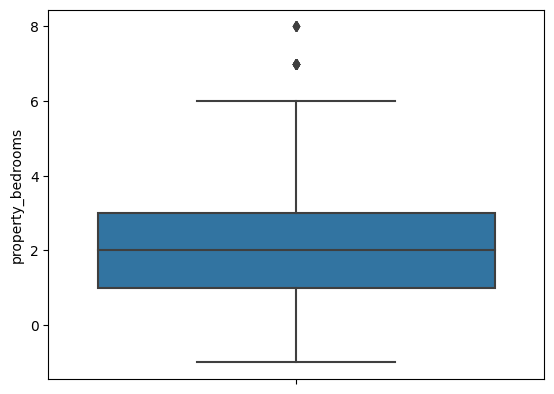

In [358]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_bedrooms)
plt.show()

Ahora probemos lás técnicas z-score y z-score modificado para las variables en el dataset

In [359]:
#z-score property_rooms
media_property_rooms=np.mean(ds_cropped_without_nans_and_anomalies.property_rooms)
std_property_rooms=np.std(ds_cropped_without_nans_and_anomalies.property_rooms)
ds_cropped_without_nans_and_anomalies['z_property_rooms']=(ds_cropped_without_nans_and_anomalies.property_rooms - media_property_rooms)/std_property_rooms

#z-score property_bedrooms
media_property_bedrooms=np.mean(ds_cropped_without_nans_and_anomalies.property_bedrooms)
std_property_bedrooms=np.std(ds_cropped_without_nans_and_anomalies.property_bedrooms)
ds_cropped_without_nans_and_anomalies['z_property_bedrooms']=(ds_cropped_without_nans_and_anomalies.property_bedrooms - media_property_bedrooms)/std_property_bedrooms

In [360]:
#z-score modificado property_rooms
mediana_property_rooms=np.median(ds_cropped_without_nans_and_anomalies.property_rooms)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_rooms-mediana_property_rooms))

ds_cropped_without_nans_and_anomalies['zm_property_rooms']=(ds_cropped_without_nans_and_anomalies.property_rooms - mediana_property_rooms)*0.6745/MAD

#z-score modificado property_bedrooms
mediana_property_bedrooms=np.median(ds_cropped_without_nans_and_anomalies.property_bedrooms)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_bedrooms-mediana_property_bedrooms))

ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']=(ds_cropped_without_nans_and_anomalies.property_bedrooms - mediana_property_bedrooms)*0.6745/MAD

In [361]:
ds_cropped_without_nans_and_anomalies.head()[["property_rooms", "z_property_rooms","zm_property_rooms","property_bedrooms", "z_property_bedrooms","zm_property_bedrooms"]]

property_rooms  z_property_rooms  zm_property_rooms  \
256070             2.0         -0.830144            -0.6745   
211207             2.0         -0.830144            -0.6745   
228948             1.0         -1.681100            -1.3490   
361800             1.0         -1.681100            -1.3490   
153179             1.0         -1.681100            -1.3490   

        property_bedrooms  z_property_bedrooms  zm_property_bedrooms  
256070                1.0            -1.005440               -0.6745  
211207                1.0            -1.005440               -0.6745  
228948                1.0            -1.005440               -0.6745  
361800                2.0             0.030911                0.0000  
153179                1.0            -1.005440               -0.6745

Verificamos si se cumple la regla de oro para la variable property_rooms:

In [362]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']>3][["property_rooms", "z_property_rooms","zm_property_rooms"]]

property_rooms  z_property_rooms  zm_property_rooms
317557             7.0          3.424635              2.698
237432             7.0          3.424635              2.698
152911             7.0          3.424635              2.698
33026              7.0          3.424635              2.698
436049             7.0          3.424635              2.698
...                ...               ...                ...
129764             7.0          3.424635              2.698
100116             7.0          3.424635              2.698
298829             7.0          3.424635              2.698
459713             7.0          3.424635              2.698
277186             7.0          3.424635              2.698

[589 rows x 3 columns]

In [363]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']<-3][["property_rooms", "z_property_rooms","zm_property_rooms"]]

Empty DataFrame
Columns: [property_rooms, z_property_rooms, zm_property_rooms]
Index: []

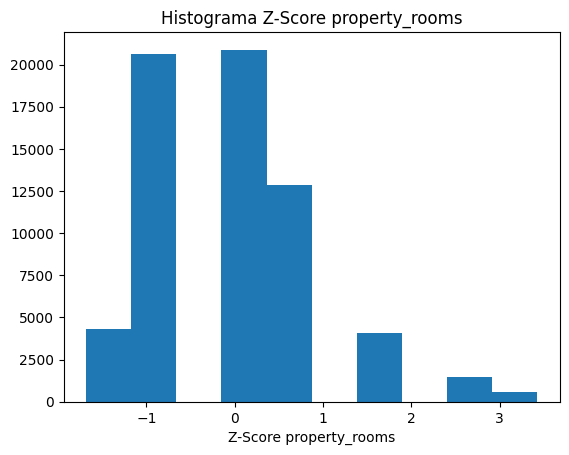

In [364]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_rooms)
plt.title('Histograma Z-Score property_rooms')
plt.xlabel('Z-Score property_rooms')
plt.show()

In [365]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

In [366]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_rooms']>3.5)][["property_rooms", "z_property_rooms","zm_property_rooms"]]

Empty DataFrame
Columns: [property_rooms, z_property_rooms, zm_property_rooms]
Index: []

In [367]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_rooms']<3.5)][["property_rooms", "z_property_rooms","zm_property_rooms"]]

property_rooms  z_property_rooms  zm_property_rooms
256070             2.0         -0.830144            -0.6745
211207             2.0         -0.830144            -0.6745
228948             1.0         -1.681100            -1.3490
361800             1.0         -1.681100            -1.3490
153179             1.0         -1.681100            -1.3490
...                ...               ...                ...
415279             2.0         -0.830144            -0.6745
149099             2.0         -0.830144            -0.6745
217366             2.0         -0.830144            -0.6745
356023             3.0          0.020812             0.0000
438863             2.0         -0.830144            -0.6745

[64219 rows x 3 columns]

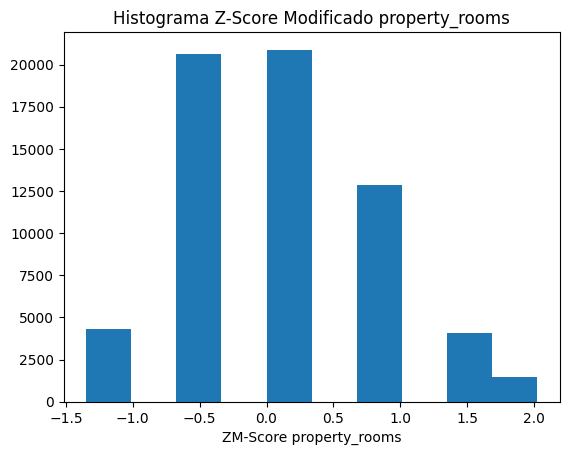

In [368]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_rooms)
plt.title('Histograma Z-Score Modificado property_rooms')
plt.xlabel('ZM-Score property_rooms')
plt.show()

In [369]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_rooms']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_rooms']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Hacemos lo mismo para la variable 'property_bedrooms' :

In [370]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']>3][["property_bedrooms", "z_property_bedrooms","zm_property_bedrooms"]]

property_bedrooms  z_property_bedrooms  zm_property_bedrooms
307877                5.0             3.139963                2.0235
145047                5.0             3.139963                2.0235
146361                6.0             4.176314                2.6980
298551                5.0             3.139963                2.0235
94710                 5.0             3.139963                2.0235
...                   ...                  ...                   ...
389464                5.0             3.139963                2.0235
452275                5.0             3.139963                2.0235
17172                 5.0             3.139963                2.0235
141135                5.0             3.139963                2.0235
321630                5.0             3.139963                2.0235

[482 rows x 3 columns]

In [371]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']<-3][["property_bedrooms", "z_property_bedrooms","zm_property_bedrooms"]]

property_bedrooms  z_property_bedrooms  zm_property_bedrooms
406880               -1.0            -3.078142               -2.0235

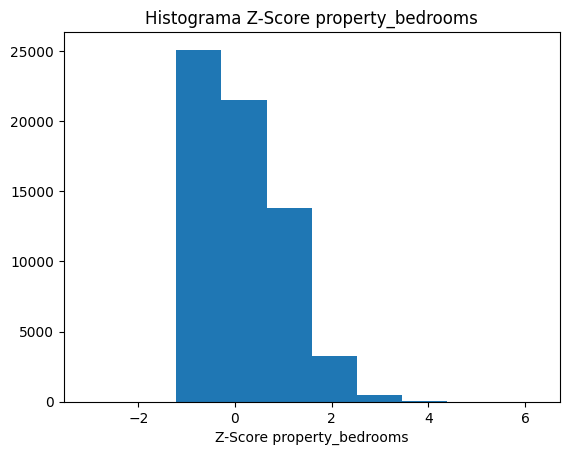

In [372]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_bedrooms)
plt.title('Histograma Z-Score property_bedrooms')
plt.xlabel('Z-Score property_bedrooms')
plt.show()

In [373]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

In [374]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']>3.5)]

Empty DataFrame
Columns: [start_date, end_date, created_on, latitud, longitud, neighborhood, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, property_title, z_property_rooms, z_property_bedrooms, zm_property_rooms, zm_property_bedrooms]
Index: []

In [375]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']<-3.5)]

Empty DataFrame
Columns: [start_date, end_date, created_on, latitud, longitud, neighborhood, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, property_title, z_property_rooms, z_property_bedrooms, zm_property_rooms, zm_property_bedrooms]
Index: []

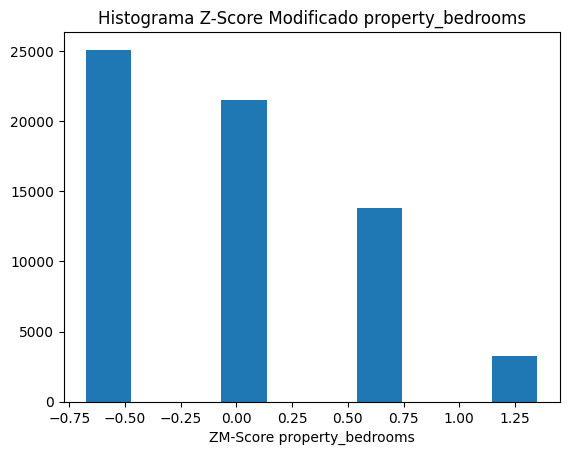

In [376]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_bedrooms)
plt.title('Histograma Z-Score Modificado property_bedrooms')
plt.xlabel('ZM-Score property_bedrooms')
plt.show()

In [377]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

3. Variable 'property_price'

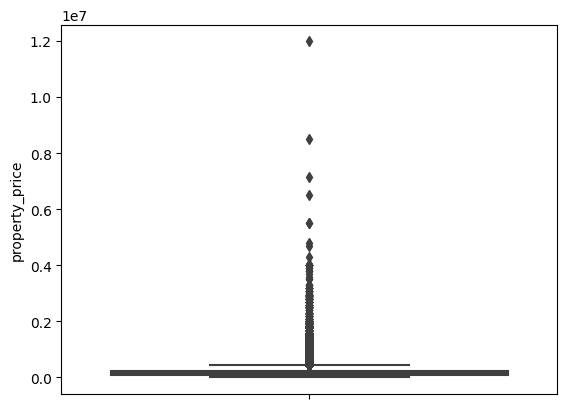

In [378]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_price)
plt.show()

In [379]:
#Cuartiles
Q1_property_price=np.quantile(ds_cropped_without_nans_and_anomalies.property_price,0.25)
Q3_property_price=np.quantile(ds_cropped_without_nans_and_anomalies.property_price,0.75)

#Rango intercuartil
IQR_property_price=Q3_property_price-Q1_property_price

#Limite inferior Outliers
out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print(out_inf)
print(out_sup)

-97500.0
442500.0


No consideramos que un cierto precio de una propiedad pueda ser outlier por sí sólo. Es mejor analizarlo en forma multivariada en base a la cantidad de habitaciones, superficie, etc. Una propiedad perfectamente podría valer 2e-7 si tiene muchísimas habitaciones y mucha superficie pero si tiene 1 habitación, por ejemplo, ya sería un caso más raro.

Ahora probemos lás técnicas z-score y z-score modificado:

In [380]:
#z-score property_price
media_property_price=np.mean(ds_cropped_without_nans_and_anomalies.property_price)
std_property_price=np.std(ds_cropped_without_nans_and_anomalies.property_price)
ds_cropped_without_nans_and_anomalies['z_property_price']=(ds_cropped_without_nans_and_anomalies.property_price - media_property_price)/std_property_price

#z-score modificado property_price
mediana_property_price=np.median(ds_cropped_without_nans_and_anomalies.property_price)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_price-mediana_property_price))

ds_cropped_without_nans_and_anomalies['zm_property_price']=(ds_cropped_without_nans_and_anomalies.property_price - mediana_property_price)*0.6745/MAD

In [381]:
ds_cropped_without_nans_and_anomalies.head()[["property_price", "z_property_price","zm_property_price"]]

property_price  z_property_price  zm_property_price
256070        198000.0         -0.096315           0.540501
211207         93000.0         -0.485006          -0.641845
228948        160000.0         -0.236984           0.112604
361800        290000.0          0.244251           1.576461
153179         83789.0         -0.519103          -0.745565

Verificamos si se cumple la regla de oro:

In [382]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']>3][["property_price", "z_property_price","zm_property_price"]]

property_price  z_property_price  zm_property_price
367726       1590000.0          5.056609          16.215025
137477       1390000.0          4.316246          13.962938
197958       1400000.0          4.353265          14.075543
181988       1040000.0          3.020612          10.021786
228899       2950000.0         10.091076          31.529215
...                ...               ...                ...
103648       2500000.0          8.425260          26.462020
45398        1150000.0          3.427811          11.260434
287335       2290000.0          7.647879          24.097329
10991        1200000.0          3.612902          11.823456
334298       1750000.0          5.648899          18.016694

[1087 rows x 3 columns]

In [383]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']<-3][["property_price", "z_property_price","zm_property_price"]]

Empty DataFrame
Columns: [property_price, z_property_price, zm_property_price]
Index: []

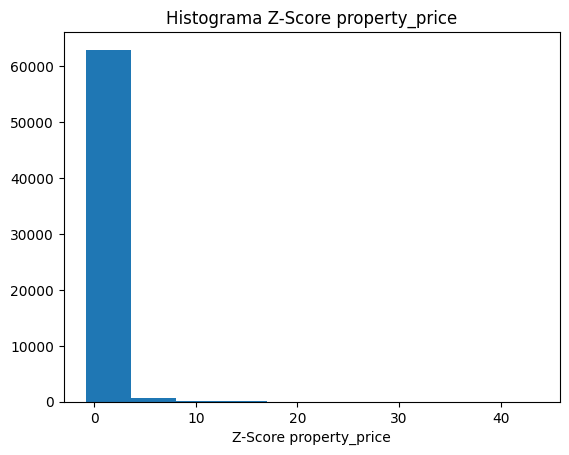

In [384]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_price)
plt.title('Histograma Z-Score property_price')
plt.xlabel('Z-Score property_price')
plt.show()

In [385]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

In [386]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']>3.5][["property_price", "z_property_price","zm_property_price"]]

property_price  z_property_price  zm_property_price
318910        550000.0          1.206723           4.504174
229171        495000.0          1.003123           3.884850
274591        780000.0          2.058140           7.094073
45841         490000.0          0.984614           3.828548
171001        785000.0          2.076649           7.150376
...                ...               ...                ...
106900        790000.0          2.095158           7.206678
264603        700000.0          1.761995           6.193239
73549         695000.0          1.743486           6.136937
94498         565000.0          1.262250           4.673080
215681        650000.0          1.576904           5.630217

[3990 rows x 3 columns]

In [387]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']<-3.5][["property_price", "z_property_price","zm_property_price"]]

Empty DataFrame
Columns: [property_price, z_property_price, zm_property_price]
Index: []

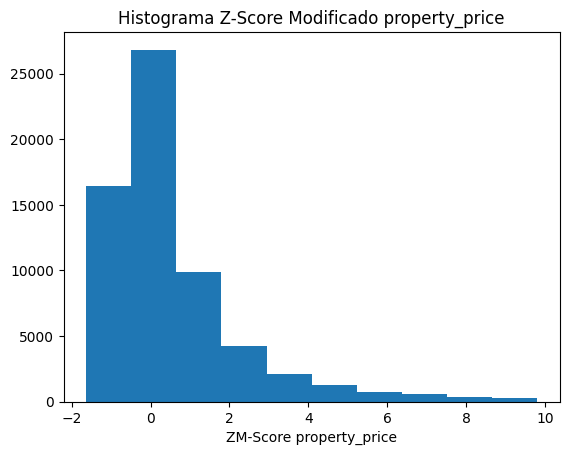

In [388]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_price)
plt.title('Histograma Z-Score Modificado property_price')
plt.xlabel('ZM-Score property_price')
plt.show()

In [389]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

4. Variable 'property_surface_total'

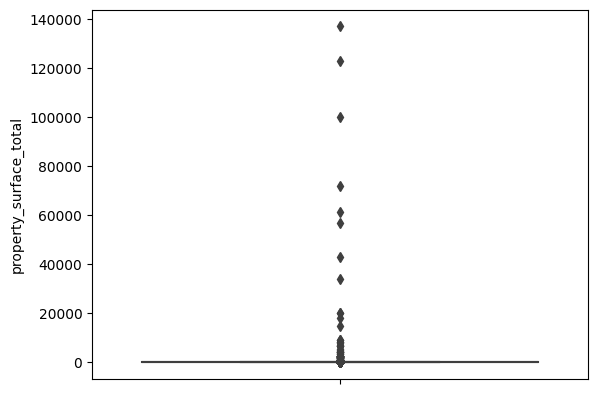

In [390]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_surface_total)
plt.show()

In [391]:
#Cuartiles
Q1_property_surface_total=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_total,0.25)
Q3_property_surface_total=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_total,0.75)

#Rango intercuartil
IQR_property_surface_total=Q3_property_surface_total-Q1_property_surface_total

#Limite inferior Outliers
out_inf=Q1_property_surface_total-1.5*IQR_property_surface_total
out_sup=Q3_property_surface_total+1.5*IQR_property_surface_total
print(out_inf)
print(out_sup)

-29.0
179.0


In [392]:
#z-score property_surface_total
media_property_surface_total=np.mean(ds_cropped_without_nans_and_anomalies.property_surface_total)
std_property_surface_total=np.std(ds_cropped_without_nans_and_anomalies.property_surface_total)
ds_cropped_without_nans_and_anomalies['z_property_surface_total']=(ds_cropped_without_nans_and_anomalies.property_surface_total - media_property_surface_total)/std_property_surface_total

#z-score modificado property_surface_total
mediana_property_surface_total=np.median(ds_cropped_without_nans_and_anomalies.property_surface_total)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_surface_total-mediana_property_surface_total))

ds_cropped_without_nans_and_anomalies['zm_property_surface_total']=(ds_cropped_without_nans_and_anomalies.property_surface_total - mediana_property_surface_total)*0.6745/MAD

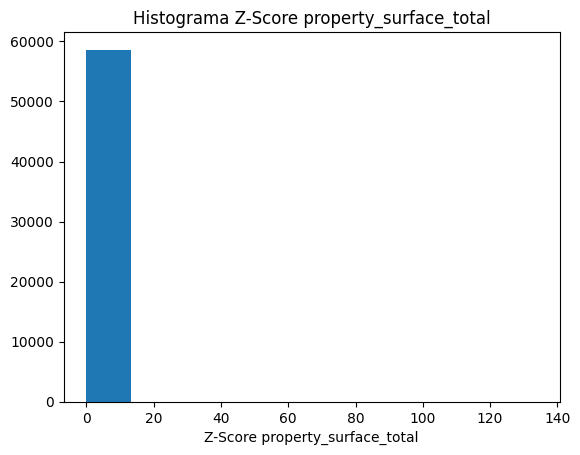

In [393]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_surface_total)
plt.title('Histograma Z-Score property_surface_total')
plt.xlabel('Z-Score property_surface_total')
plt.show()

In [394]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_surface_total']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_surface_total']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)


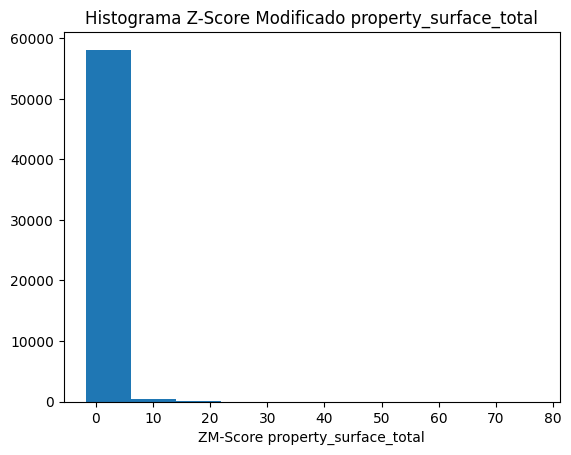

In [395]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_surface_total)
plt.title('Histograma Z-Score Modificado property_surface_total')
plt.xlabel('ZM-Score property_surface_total')
plt.show()

In [396]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_surface_total']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_surface_total']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

5. Variable 'propery_surface_covered'

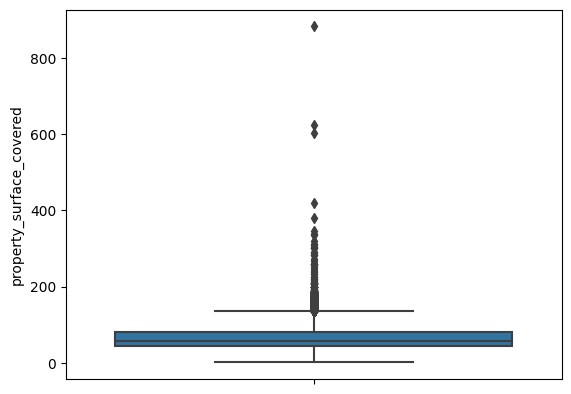

In [397]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_surface_covered)
plt.show()

In [398]:
#Cuartiles
Q1_property_surface_covered=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_covered,0.25)
Q3_property_surface_covered=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_covered,0.75)

#Rango intercuartil
IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

#Limite inferior Outliers
out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print(out_inf)
print(out_sup)

-12.5
135.5


In [399]:
#z-score property_surface_covered
media_property_surface_covered=np.mean(ds_cropped_without_nans_and_anomalies.property_surface_covered)
std_property_surface_covered=np.std(ds_cropped_without_nans_and_anomalies.property_surface_covered)
ds_cropped_without_nans_and_anomalies['z_property_surface_covered']=(ds_cropped_without_nans_and_anomalies.property_surface_covered - media_property_surface_covered)/std_property_surface_covered

#z-score modificado property_surface_covered
mediana_property_surface_covered=np.median(ds_cropped_without_nans_and_anomalies.property_surface_covered)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_surface_covered-mediana_property_surface_covered))

ds_cropped_without_nans_and_anomalies['zm_property_surface_covered']=(ds_cropped_without_nans_and_anomalies.property_surface_covered - mediana_property_surface_covered)*0.6745/MAD

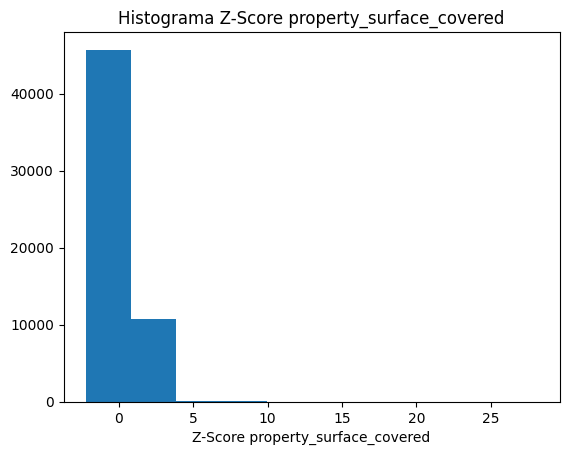

In [400]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_surface_covered)
plt.title('Histograma Z-Score property_surface_covered')
plt.xlabel('Z-Score property_surface_covered')
plt.show()

In [401]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_surface_covered']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_surface_covered']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

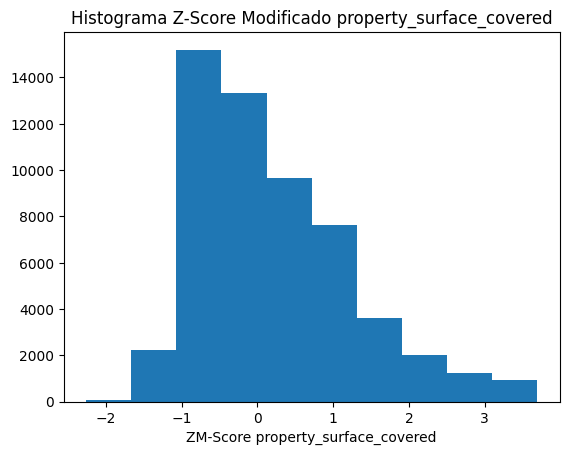

In [402]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_surface_covered)
plt.title('Histograma Z-Score Modificado property_surface_covered')
plt.xlabel('ZM-Score property_surface_covered')
plt.show()

In [403]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_surface_covered']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_surface_covered']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

### Análisis Multivariado

Vamos a analizar la presencia de outliers multivariados. 

### Local Outlier Factor (LOF)

1. Exploremos las variables 'property_rooms' y 'property_bedrooms'

In [404]:
from sklearn.neighbors import LocalOutlierFactor

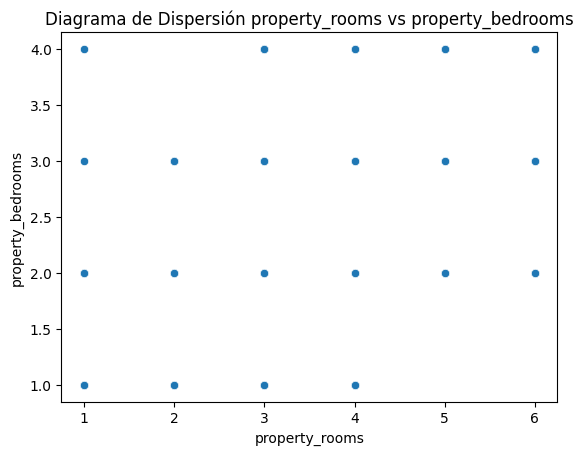

In [405]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_bedrooms")
plt.title('Diagrama de Dispersión property_rooms vs property_bedrooms')
plt.show()

In [406]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_bedrooms']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [407]:
ds_scores.head()

start_date    end_date  created_on    latitud   longitud neighborhood  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638      Coghlan   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517    Caballito   
228948  2021-03-08  2021-06-05  2021-03-08 -34.577033 -58.423367      Palermo   
361800  2021-01-16  2021-10-09  2021-01-16 -34.580210 -58.412815      Palermo   
153179  2021-12-09  2021-12-16  2021-12-09 -34.582107 -58.448826      Palermo   

       property_type  property_rooms  property_bedrooms  \
256070  Departamento             2.0                1.0   
211207  Departamento             2.0                1.0   
228948  Departamento             1.0                1.0   
361800  Departamento             1.0                2.0   
153179  Departamento             1.0                1.0   

        property_surface_total  ...  z_property_bedrooms  zm_property_rooms  \
256070               65.000000  ...            -1.005440            -0.6745   
211207               41.000000  ...            -1.005440            -0.6745   
228948               49.000000  ...            -1.005440            -1.3490   
361800              114.949644  ...             0.030911            -1.3490   
153179               36.000000  ...            -1.005440            -1.3490   

       zm_property_bedrooms  z_property_price  zm_property_price  \
256070              -0.6745         -0.096315           0.540501   
211207              -0.6745         -0.485006          -0.641845   
228948              -0.6745         -0.236984           0.112604   
361800               0.0000          0.244251           1.576461   
153179              -0.6745         -0.519103          -0.745565   

        z_property_surface_total  zm_property_surface_total  \
256070                 -0.030282                  -0.087978   
211207                 -0.053766                  -0.791804   
228948                 -0.045938                  -0.557196   
361800                  0.018594                   1.376849   
153179                 -0.058658                  -0.938435   

        z_property_surface_covered  zm_property_surface_covered  scores  
256070                   -0.390705                    -0.198382    -1.0  
211207                   -1.008472                    -0.912559    -1.0  
228948                   -0.699589                    -0.555471    -1.0  
361800                    0.467304                     0.793529    -1.0  
153179                   -1.145753                    -1.071265    -1.0  

[5 rows x 24 columns]

Visualicemos los datos y sus scores en un diagrama de dispersión

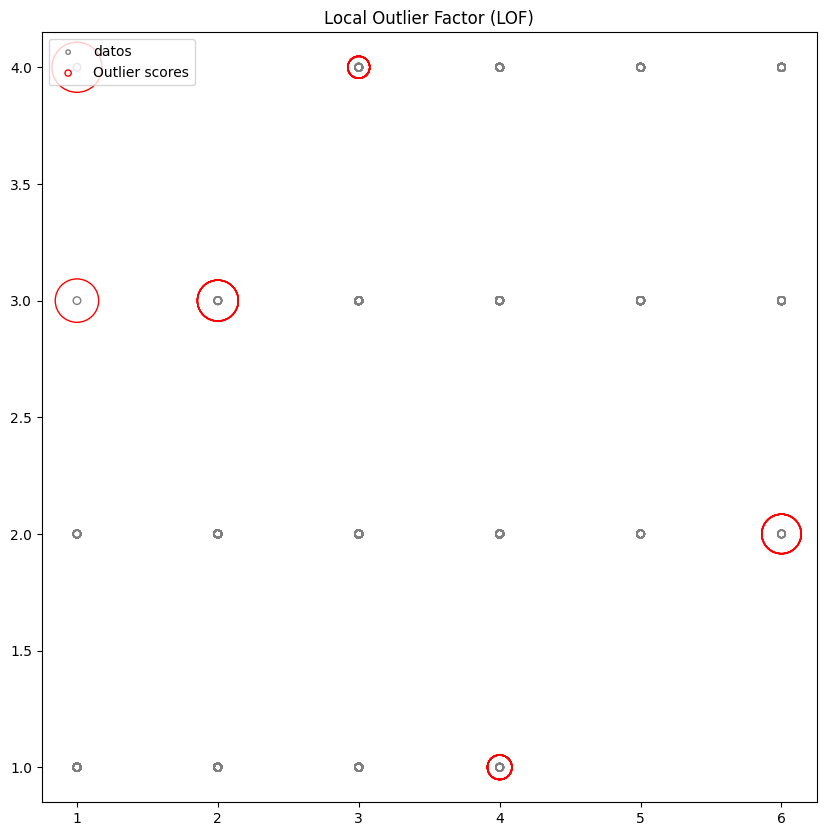

In [408]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_bedrooms.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_bedrooms.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

TODO: Fijar un umbral y armar un scatter plot mostrando con diferentes colores los outliers de los datos normales

2. Exploremos las variables 'property_rooms' y 'property_surface_total'

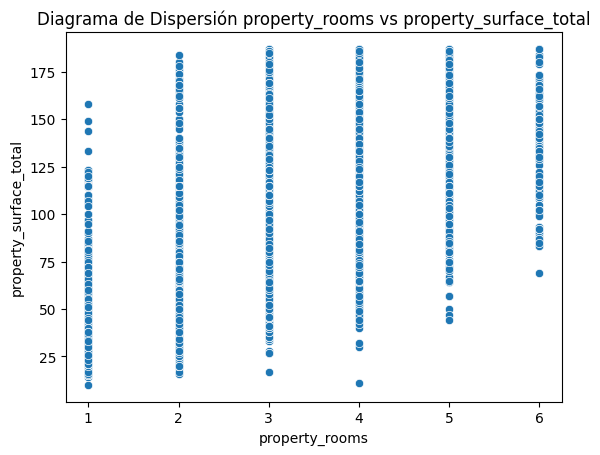

In [409]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_surface_total")
plt.title('Diagrama de Dispersión property_rooms vs property_surface_total')
plt.show()

In [410]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_surface_total']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [411]:
ds_scores.head()

start_date    end_date  created_on    latitud   longitud neighborhood  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638      Coghlan   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517    Caballito   
228948  2021-03-08  2021-06-05  2021-03-08 -34.577033 -58.423367      Palermo   
361800  2021-01-16  2021-10-09  2021-01-16 -34.580210 -58.412815      Palermo   
153179  2021-12-09  2021-12-16  2021-12-09 -34.582107 -58.448826      Palermo   

       property_type  property_rooms  property_bedrooms  \
256070  Departamento             2.0                1.0   
211207  Departamento             2.0                1.0   
228948  Departamento             1.0                1.0   
361800  Departamento             1.0                2.0   
153179  Departamento             1.0                1.0   

        property_surface_total  ...  z_property_bedrooms  zm_property_rooms  \
256070               65.000000  ...            -1.005440            -0.6745   
211207               41.000000  ...            -1.005440            -0.6745   
228948               49.000000  ...            -1.005440            -1.3490   
361800              114.949644  ...             0.030911            -1.3490   
153179               36.000000  ...            -1.005440            -1.3490   

       zm_property_bedrooms  z_property_price  zm_property_price  \
256070              -0.6745         -0.096315           0.540501   
211207              -0.6745         -0.485006          -0.641845   
228948              -0.6745         -0.236984           0.112604   
361800               0.0000          0.244251           1.576461   
153179              -0.6745         -0.519103          -0.745565   

        z_property_surface_total  zm_property_surface_total  \
256070                 -0.030282                  -0.087978   
211207                 -0.053766                  -0.791804   
228948                 -0.045938                  -0.557196   
361800                  0.018594                   1.376849   
153179                 -0.058658                  -0.938435   

        z_property_surface_covered  zm_property_surface_covered  scores  
256070                   -0.390705                    -0.198382    -1.0  
211207                   -1.008472                    -0.912559    -1.0  
228948                   -0.699589                    -0.555471    -1.0  
361800                    0.467304                     0.793529    -1.0  
153179                   -1.145753                    -1.071265    -1.0  

[5 rows x 24 columns]

Visualicemos los datos y sus scores en un diagrama de dispersión

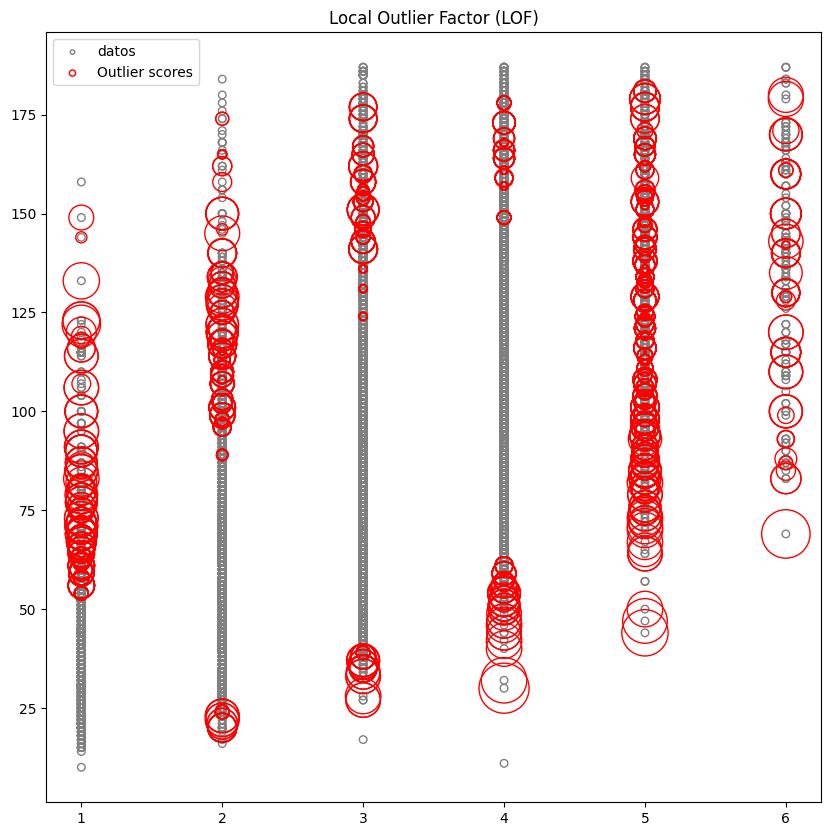

In [412]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_surface_total.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_surface_total.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

TODO: Fijar un umbral y armar un scatter plot mostrando con diferentes colores los outliers de los datos normales

3. Exploremos las variables 'property_rooms' y 'property_price'

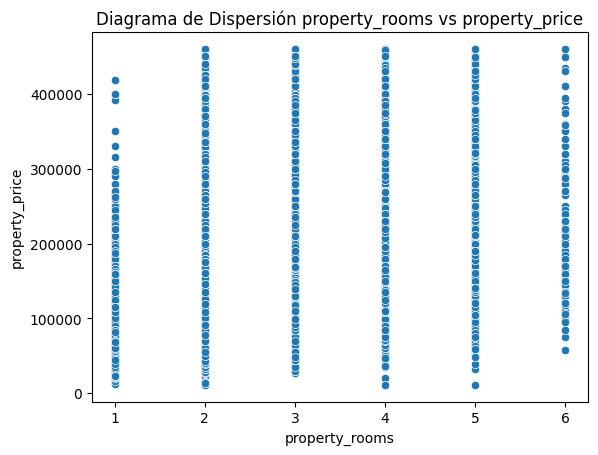

In [413]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_price")
plt.title('Diagrama de Dispersión property_rooms vs property_price')
plt.show()

In [414]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_price']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [415]:
ds_scores.head()

start_date    end_date  created_on    latitud   longitud neighborhood  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638      Coghlan   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517    Caballito   
228948  2021-03-08  2021-06-05  2021-03-08 -34.577033 -58.423367      Palermo   
361800  2021-01-16  2021-10-09  2021-01-16 -34.580210 -58.412815      Palermo   
153179  2021-12-09  2021-12-16  2021-12-09 -34.582107 -58.448826      Palermo   

       property_type  property_rooms  property_bedrooms  \
256070  Departamento             2.0                1.0   
211207  Departamento             2.0                1.0   
228948  Departamento             1.0                1.0   
361800  Departamento             1.0                2.0   
153179  Departamento             1.0                1.0   

        property_surface_total  ...  z_property_bedrooms  zm_property_rooms  \
256070               65.000000  ...            -1.005440            -0.6745   
211207               41.000000  ...            -1.005440            -0.6745   
228948               49.000000  ...            -1.005440            -1.3490   
361800              114.949644  ...             0.030911            -1.3490   
153179               36.000000  ...            -1.005440            -1.3490   

       zm_property_bedrooms  z_property_price  zm_property_price  \
256070              -0.6745         -0.096315           0.540501   
211207              -0.6745         -0.485006          -0.641845   
228948              -0.6745         -0.236984           0.112604   
361800               0.0000          0.244251           1.576461   
153179              -0.6745         -0.519103          -0.745565   

        z_property_surface_total  zm_property_surface_total  \
256070                 -0.030282                  -0.087978   
211207                 -0.053766                  -0.791804   
228948                 -0.045938                  -0.557196   
361800                  0.018594                   1.376849   
153179                 -0.058658                  -0.938435   

        z_property_surface_covered  zm_property_surface_covered        scores  
256070                   -0.390705                    -0.198382 -1.000000e+00  
211207                   -1.008472                    -0.912559 -1.000000e+00  
228948                   -0.699589                    -0.555471 -5.613909e+09  
361800                    0.467304                     0.793529 -8.500000e+09  
153179                   -1.145753                    -1.071265 -7.380163e+10  

[5 rows x 24 columns]

Visualicemos los datos y sus scores en un diagrama de dispersión

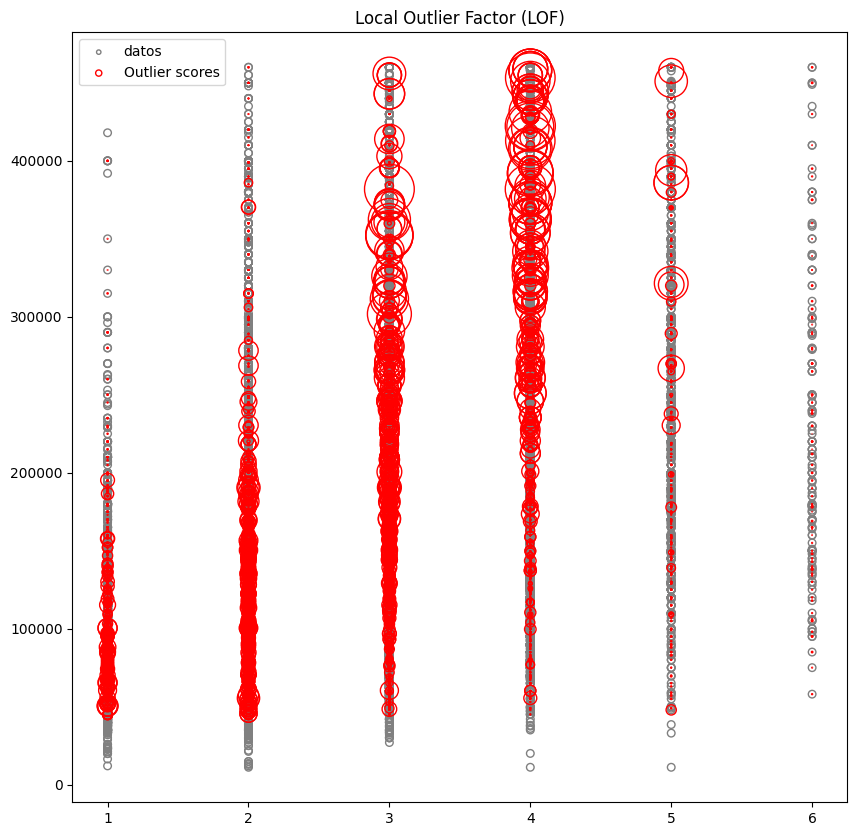

In [416]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_price.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_price.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

Analizamos la relación entre el precio de venta y los metros de superficie:

4. Exploremos las variables 'property_price' y 'property_surface_total'

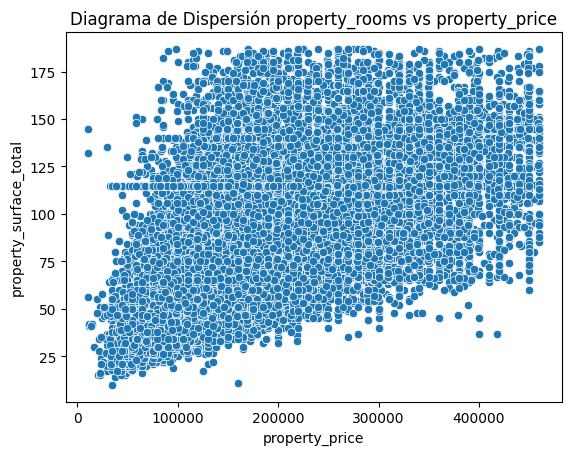

In [417]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_price",y="property_surface_total")
plt.title('Diagrama de Dispersión property_rooms vs property_price')
plt.show()

In [418]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_price','property_surface_total']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [419]:
ds_scores.head()

start_date    end_date  created_on    latitud   longitud neighborhood  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638      Coghlan   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517    Caballito   
228948  2021-03-08  2021-06-05  2021-03-08 -34.577033 -58.423367      Palermo   
361800  2021-01-16  2021-10-09  2021-01-16 -34.580210 -58.412815      Palermo   
153179  2021-12-09  2021-12-16  2021-12-09 -34.582107 -58.448826      Palermo   

       property_type  property_rooms  property_bedrooms  \
256070  Departamento             2.0                1.0   
211207  Departamento             2.0                1.0   
228948  Departamento             1.0                1.0   
361800  Departamento             1.0                2.0   
153179  Departamento             1.0                1.0   

        property_surface_total  ...  z_property_bedrooms  zm_property_rooms  \
256070               65.000000  ...            -1.005440            -0.6745   
211207               41.000000  ...            -1.005440            -0.6745   
228948               49.000000  ...            -1.005440            -1.3490   
361800              114.949644  ...             0.030911            -1.3490   
153179               36.000000  ...            -1.005440            -1.3490   

       zm_property_bedrooms  z_property_price  zm_property_price  \
256070              -0.6745         -0.096315           0.540501   
211207              -0.6745         -0.485006          -0.641845   
228948              -0.6745         -0.236984           0.112604   
361800               0.0000          0.244251           1.576461   
153179              -0.6745         -0.519103          -0.745565   

        z_property_surface_total  zm_property_surface_total  \
256070                 -0.030282                  -0.087978   
211207                 -0.053766                  -0.791804   
228948                 -0.045938                  -0.557196   
361800                  0.018594                   1.376849   
153179                 -0.058658                  -0.938435   

        z_property_surface_covered  zm_property_surface_covered    scores  
256070                   -0.390705                    -0.198382 -1.012500  
211207                   -1.008472                    -0.912559 -1.072857  
228948                   -0.699589                    -0.555471 -0.933333  
361800                    0.467304                     0.793529 -1.000000  
153179                   -1.145753                    -1.071265 -4.531963  

[5 rows x 24 columns]

Visualicemos los datos y sus scores en un diagrama de dispersión

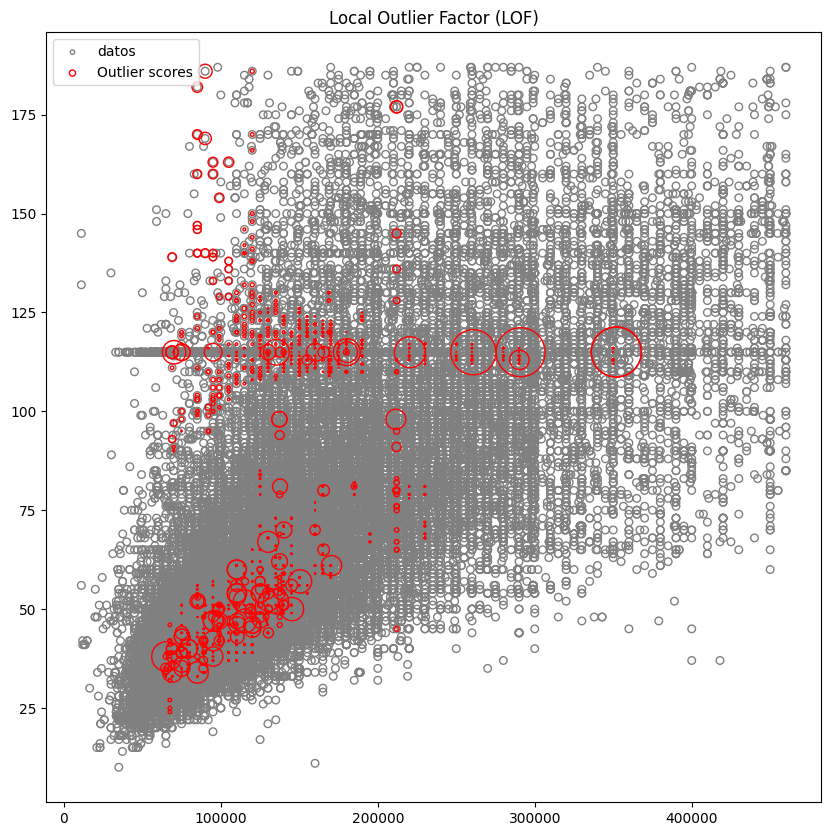

In [420]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_price.values,ds_scores.property_surface_total.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_price.values,ds_scores.property_surface_total.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

## d) Reducción de la dimensionalidad

Vamos a crear un nuevo dataset que resulte de aplicar una reducción de dimensionalidad sobre el dataset que se obtuvo al finalizar el preprocesamiento.

### PCA - Análisis de Componentes Principales

Procedimiento matemático por el cual se transforma un conjunto de variables correlacionadas en un conjunto de variables no correlacionadas de menor dimensión. Estas nuevas variables se obtiene a partir de combinaciones lineales de las variables originales.
Estas nuevas variables son las que se denominan Componentes Principales

Esta técnica intenta hallar aquellas combinaciones lineales de las variables originales que maximizan la varianza (minimizan la pérdida de información original)

Esta técnica no requiere supuestos por lo que puede aplicarse siempre, sin embargo solo tiene sentido aplicarla si las variables originales estan relacionados entre si

El objetivo es reducir la dimensión del problema, es decir, descartar la información redundante

PCA ejecutado en 6 pasos:

1. Normalizar los atributos

undefined. Calcular la matriz de covarianza

undefined. Calcular autovalores y autovectores

undefined. Ordenar los autovalores por orden descendente para elegir las componentes a utilizar

undefined. Ordenar los autovectores en función del orden de los autovalores

undefined. Armar la matriz de transformación

Como PCA las columnas deben ser numéricas, deberíamos realizar alguna transformación de las variables categóricas. Pero, PCA no es bueno en matrices con tantos huecos como genera One Hot. Por lo tanto, trabajamos sólo con las variables numéricas y luego sumamos al nuevo dataset las categóricas transformadas.

In [464]:
dataset_pca = ds_cropped_without_nans_and_anomalies.copy()

columnas_a_borrar = ['start_date','end_date','created_on','property_type','neighborhood', 'property_title', 'latitud', 'longitud']

columnas_borradas = dataset_pca.filter(columnas_a_borrar, axis=1)
dataset_pca.drop(columns=columnas_a_borrar, inplace=True)

Ahora que todas las variables son numéricas, aplicamos PCA:

In [422]:
from sklearn.preprocessing import StandardScaler


x = dataset_pca.values
x = StandardScaler().fit_transform(x)

In [423]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3', 'cp_4', 'cp_5'])

In [424]:
pca.explained_variance_ratio_

array([0.77354891, 0.11884156, 0.0609935 , 0.0324351 , 0.01418094])

In [425]:
pca.get_covariance()

array([[1.00001797, 0.92868578, 0.69843991, 0.77145762, 0.55407123,
        1.00001797, 0.92868578, 1.00001797, 0.92868578, 0.55407123,
        0.55407123, 0.69843991, 0.69843991, 0.77145762, 0.77145762],
       [0.92868578, 1.00001797, 0.68136283, 0.759053  , 0.54816861,
        0.92868578, 1.00001797, 0.92868578, 1.00001797, 0.54816861,
        0.54816861, 0.68136283, 0.68136283, 0.759053  , 0.759053  ],
       [0.69843991, 0.68136283, 1.00001797, 0.81256136, 0.66317532,
        0.69843991, 0.68136283, 0.69843991, 0.68136283, 0.66317532,
        0.66317532, 1.00001797, 1.00001797, 0.81256136, 0.81256136],
       [0.77145762, 0.759053  , 0.81256136, 1.00001797, 0.72473389,
        0.77145762, 0.759053  , 0.77145762, 0.759053  , 0.72473389,
        0.72473389, 0.81256136, 0.81256136, 1.00001797, 1.00001797],
       [0.55407123, 0.54816861, 0.66317532, 0.72473389, 1.00001797,
        0.55407123, 0.54816861, 0.55407123, 0.54816861, 1.00001797,
        1.00001797, 0.66317532, 0.66317532, 

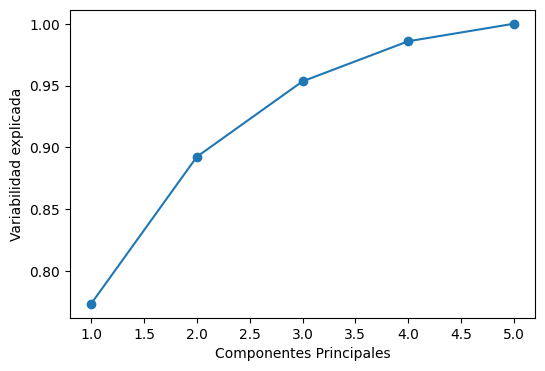

In [426]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Nos quedaremos con 4 componentes principales ya que logramos una variablidad explicada de aproximadamente 95%

Seleccionamos 4 componentes principales y los juntamos con las columnas categoricas de nuestro dataset

In [427]:
new_pca_df = pca_df_aux.iloc[:,:4]
ds_with_categoric = ds_cropped_without_nans_and_anomalies[['start_date','end_date','created_on','property_type','neighborhood', 'property_title', 'latitud', 'longitud']]
reduced_df = pd.concat([new_pca_df.reset_index(drop=True), ds_with_categoric.reset_index(drop=True)], axis=1, join="inner")

reduced_df

cp_1      cp_2      cp_3      cp_4  start_date    end_date  \
0     -1.547768  1.765547 -0.269888  0.150372  2021-11-03  2022-02-02   
1     -3.551701 -0.180603 -0.197901  0.144542  2021-11-16  2021-11-18   
2     -3.369834  1.816588 -0.224672 -0.098460  2021-03-08  2021-06-05   
3      1.328055  3.698273  0.750289  0.385542  2021-01-16  2021-10-09   
4     -4.717955  0.455829  0.002764 -0.002895  2021-12-09  2021-12-16   
...         ...       ...       ...       ...         ...         ...   
55640 -2.370940  0.844589 -0.234200 -0.297398  2021-09-08  2021-09-29   
55641 -2.090126  1.124696 -0.122818 -0.070397  2021-05-12  2021-06-05   
55642 -2.628333  0.641328 -0.137648  0.019550  2021-09-04  2021-09-26   
55643  1.740294 -0.152323  2.085857  0.729158  2021-11-18  2022-01-27   
55644 -0.905917  1.629131 -0.139353 -2.443769  2021-04-23  2021-06-05   

       created_on property_type neighborhood  \
0      2021-11-03  Departamento      Coghlan   
1      2021-11-16  Departamento    Caballito   
2      2021-03-08  Departamento      Palermo   
3      2021-01-16  Departamento      Palermo   
4      2021-12-09  Departamento      Palermo   
...           ...           ...          ...   
55640  2021-09-08  Departamento     Belgrano   
55641  2021-05-12  Departamento      Coghlan   
55642  2021-09-04  Departamento     Belgrano   
55643  2021-11-18            PH      Almagro   
55644  2021-04-23  Departamento     Belgrano   

                                          property_title    latitud   longitud  
0                                      1 - Holmberg 2700 -34.566536 -58.479638  
1      Departamento de 2 ambientes con balcón aterraz... -34.592497 -58.449517  
2      Departamento - Monoambiente - Palermo Nuevo - ... -34.577033 -58.423367  
3                                Departamento en Palermo -34.580210 -58.412815  
4                   Departamento 1 ambiente - OM Palermo -34.582107 -58.448826  
...                                                  ...        ...        ...  
55640  DEPARTAMENTO · 2 AMBIENTES · 11 DE SEPTIEMBRE ... -34.552470 -58.456270  
55641                             Departamento - Coghlan -34.559379 -58.480078  
55642  VENTA DEPARTAMENTO BELGRANO R 2 AMBIENTES AMEN... -34.568071 -58.458146  
55643                                       PH - Almagro -34.604955 -58.422891  
55644  BELGRANO - 2 ambientes de 50m2 en edificio ful... -34.561937 -58.453636  

[55645 rows x 12 columns]

Nos guardamos el dataset reducido

In [428]:
reduced_df.to_csv("datasets/reducido.csv")
ds_cropped_without_nans_and_anomalies.to_csv("datasets/ds.csv")

# 2. Agrupamiento

Antes que nada, como para aplicar algunos métodos las columnas deben ser numéricas, convertimos las variables 'property_type' y 'neighborhood' que son del tipo categóricas a numéricas para poder aplicar las técnicas al modelo.

Variables Dummies -- One Hot Encoding

Algunos métodos analíticos requieren que las variables predictoras sean numéricas. Cuando tenemos categóricas, podemos recodificar la variable en una o más variables Dummies.

La forma de hacer esto es llevando cada categoría a una variable y completando con 0 o 1, es decir, llevar las categorías a variables que tomen valores binarios. De K categorías las podemos llevar a K-1 variables Dummies: si las K-1 están en 0 sabemos que es la otra que no está. Nunca va a pasar que haya más de un 1 porque son categorías excluyentes.

In [429]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder() 
ds_cropped_without_nans_and_anomalies_ohe=ds_cropped_without_nans_and_anomalies.copy()

property_type_encoded = ohe.fit_transform(ds_cropped_without_nans_and_anomalies_ohe[['property_type']].astype(str)).todense().astype(int)

property_type_encoded = pd.DataFrame(property_type_encoded).add_prefix('property_type_')
display(property_type_encoded)

property_type_0  property_type_1  property_type_2
0                    0                1                0
1                    0                1                0
2                    0                1                0
3                    0                1                0
4                    0                1                0
...                ...              ...              ...
55640                0                1                0
55641                0                1                0
55642                0                1                0
55643                0                0                1
55644                0                1                0

[55645 rows x 3 columns]

Para evitar problemas de colinealidad en los features se debe excluir una categoría del set (la ausencia de todas - vector de 0s - indica la presencia de la categoría faltante). La función de pandas ya viene con una parámetro para esto drop_first=True:

In [430]:
df_dummies = pd.get_dummies(ds_cropped_without_nans_and_anomalies_ohe, columns=['property_type'], drop_first=True)
display(df_dummies.head(2))
print(df_dummies.shape)

start_date    end_date  created_on    latitud   longitud neighborhood  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638      Coghlan   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517    Caballito   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0                1.0                    65.0   
211207             2.0                1.0                    41.0   

        property_surface_covered  ...  zm_property_rooms zm_property_bedrooms  \
256070                      53.0  ...            -0.6745              -0.6745   
211207                      35.0  ...            -0.6745              -0.6745   

        z_property_price  zm_property_price  z_property_surface_total  \
256070         -0.096315           0.540501                 -0.030282   
211207         -0.485006          -0.641845                 -0.053766   

        zm_property_surface_total  z_property_surface_covered  \
256070                  -0.087978                   -0.390705   
211207                  -0.791804                   -1.008472   

        zm_property_surface_covered  property_type_Departamento  \
256070                    -0.198382                           1   
211207                    -0.912559                           1   

        property_type_PH  
256070                 0  
211207                 0  

[2 rows x 24 columns]

(55645, 24)


Tambien, hacemos lo mismo para la variable 'neighborhood':

In [431]:
neighborhood_encoded = ohe.fit_transform(df_dummies[['neighborhood']].astype(str)).todense().astype(int)

neighborhood_encoded = pd.DataFrame(neighborhood_encoded).add_prefix('neighborhood_')
display(neighborhood_encoded)

neighborhood_0  neighborhood_1  neighborhood_2  neighborhood_3  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
55640               0               0               0               0   
55641               0               0               0               0   
55642               0               0               0               0   
55643               0               0               1               0   
55644               0               0               0               0   

       neighborhood_4  neighborhood_5  neighborhood_6  neighborhood_7  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
55640               0               0               1               0   
55641               0               0               0               0   
55642               0               0               1               0   
55643               0               0               0               0   
55644               0               0               1               0   

       neighborhood_8  neighborhood_9  ...  neighborhood_49  neighborhood_50  \
0                   0               0  ...                0                0   
1                   0               0  ...                0                0   
2                   0               0  ...                0                0   
3                   0               0  ...                0                0   
4                   0               0  ...                0                0   
...               ...             ...  ...              ...              ...   
55640               0               0  ...                0                0   
55641               0               0  ...                0                0   
55642               0               0  ...                0                0   
55643               0               0  ...                0                0   
55644               0               0  ...                0                0   

       neighborhood_51  neighborhood_52  neighborhood_53  neighborhood_54  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
55640                0                0                0                0   
55641                0                0                0                0   
55642                0                0                0                0   
55643                0                0                0                0   
55644                0                0                0                0   

       neighborhood_55  neighborhood_56  neighborhood_57  neighborhood_58  
0                    0                0                0                0  
1                    0                0                0                0  
2                    0                0                0                0  
3                    0                0                0       

In [432]:
df_dummies = pd.get_dummies(df_dummies, columns=['neighborhood'], drop_first=True)
display(df_dummies.head(2))
print(df_dummies.shape)

start_date    end_date  created_on    latitud   longitud  \
256070  2021-11-03  2022-02-02  2021-11-03 -34.566536 -58.479638   
211207  2021-11-16  2021-11-18  2021-11-16 -34.592497 -58.449517   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0                1.0                    65.0   
211207             2.0                1.0                    41.0   

        property_surface_covered  property_price  ...  \
256070                      53.0        198000.0  ...   
211207                      35.0         93000.0  ...   

       neighborhood_Villa Lugano  neighborhood_Villa Luro  \
256070                         0                        0   
211207                         0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
256070                           0                              0   
211207                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
256070                        0                             0   
211207                        0                             0   

        neighborhood_Villa Santa Rita  neighborhood_Villa Soldati  \
256070                              0                           0   
211207                              0                           0   

        neighborhood_Villa Urquiza  neighborhood_Villa del Parque  
256070                           0                              0  
211207                           0                              0  

[2 rows x 80 columns]

(55645, 80)


También, para los atributos 'start_date', 'end_date' y 'created_on' los convertiremos usando el método pandas.to_datetime() para cambiar el tiempo de String a Date

In [433]:
df_converted_date = df_dummies.copy()
df_converted_date["start_date"] = pd.to_datetime(df_converted_date["start_date"], errors = 'coerce')
df_converted_date["end_date"] = pd.to_datetime(df_converted_date["end_date"], errors = 'coerce')
df_converted_date["created_on"] = pd.to_datetime(df_converted_date["created_on"], errors = 'coerce')

df_converted_date.dtypes

start_date                       datetime64[ns]
end_date                         datetime64[ns]
created_on                       datetime64[ns]
latitud                                 float64
longitud                                float64
                                      ...      
neighborhood_Villa Riachuelo              uint8
neighborhood_Villa Santa Rita             uint8
neighborhood_Villa Soldati                uint8
neighborhood_Villa Urquiza                uint8
neighborhood_Villa del Parque             uint8
Length: 80, dtype: object

In [434]:
df_converted_date.head(2)

start_date   end_date created_on    latitud   longitud  property_rooms  \
256070 2021-11-03 2022-02-02 2021-11-03 -34.566536 -58.479638             2.0   
211207 2021-11-16 2021-11-18 2021-11-16 -34.592497 -58.449517             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
256070                1.0                    65.0                      53.0   
211207                1.0                    41.0                      35.0   

        property_price  ... neighborhood_Villa Lugano  \
256070        198000.0  ...                         0   
211207         93000.0  ...                         0   

        neighborhood_Villa Luro  neighborhood_Villa Ortuzar  \
256070                        0                           0   
211207                        0                           0   

        neighborhood_Villa Pueyrredón  neighborhood_Villa Real  \
256070                              0                        0   
211207                              0                        0   

        neighborhood_Villa Riachuelo  neighborhood_Villa Santa Rita  \
256070                             0                              0   
211207                             0                              0   

        neighborhood_Villa Soldati  neighborhood_Villa Urquiza  \
256070                           0                           0   
211207                           0                           0   

        neighborhood_Villa del Parque  
256070                              0  
211207                              0  

[2 rows x 80 columns]

Ahora, las convierto a segundos para que queden variables numéricas:

In [435]:
min(df_converted_date['start_date'])

Timestamp('2021-01-01 00:00:00')

In [436]:
min(df_converted_date['end_date'])

Timestamp('2021-01-02 00:00:00')

In [437]:
min(df_converted_date['created_on'])

Timestamp('2021-01-01 00:00:00')

In [438]:
base_dt = pd.to_datetime('2021/01/01 00:00:00')

df_converted_date['start_date'] = (df_converted_date['start_date'] - base_dt).dt.total_seconds()
df_converted_date['end_date'] = (df_converted_date['end_date']- base_dt).dt.total_seconds()
df_converted_date['created_on'] = (df_converted_date['created_on']- base_dt).dt.total_seconds()

df_converted_date.dtypes

start_date                       float64
end_date                         float64
created_on                       float64
latitud                          float64
longitud                         float64
                                  ...   
neighborhood_Villa Riachuelo       uint8
neighborhood_Villa Santa Rita      uint8
neighborhood_Villa Soldati         uint8
neighborhood_Villa Urquiza         uint8
neighborhood_Villa del Parque      uint8
Length: 80, dtype: object

In [439]:
df_converted_date.head(2)

start_date    end_date  created_on    latitud   longitud  \
256070  26438400.0  34300800.0  26438400.0 -34.566536 -58.479638   
211207  27561600.0  27734400.0  27561600.0 -34.592497 -58.449517   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0                1.0                    65.0   
211207             2.0                1.0                    41.0   

        property_surface_covered  property_price  ...  \
256070                      53.0        198000.0  ...   
211207                      35.0         93000.0  ...   

       neighborhood_Villa Lugano  neighborhood_Villa Luro  \
256070                         0                        0   
211207                         0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
256070                           0                              0   
211207                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
256070                        0                             0   
211207                        0                             0   

        neighborhood_Villa Santa Rita  neighborhood_Villa Soldati  \
256070                              0                           0   
211207                              0                           0   

        neighborhood_Villa Urquiza  neighborhood_Villa del Parque  
256070                           0                              0  
211207                           0                              0  

[2 rows x 80 columns]

In [440]:
# df_converted_date.dropna(inplace=True)

Convertimos todo este proceso a una funcion, para poder aplicarlo al dataset reducido obtenido por PCA y lo guardamos

Adicionalmente, borramos la columna property_title ya que no va ser utilizado

In [500]:
def ohe(df):
  df_dummies = pd.get_dummies(df, columns=['property_type'], drop_first=True)
  df_dummies = pd.get_dummies(df_dummies, columns=['neighborhood'], drop_first=True)

  base_dt = pd.to_datetime('2021-01-01 00:00:00')

  df_dummies["start_date"] = pd.to_datetime(df_dummies["start_date"], errors = 'coerce')
  df_dummies["end_date"] = pd.to_datetime(df_dummies["end_date"], errors = 'coerce')
  df_dummies["created_on"] = pd.to_datetime(df_dummies["created_on"], errors = 'coerce')  

  df_dummies['start_date'] = (df_dummies['start_date'] - base_dt).dt.total_seconds()
  df_dummies['end_date'] = (df_dummies['end_date']- base_dt).dt.total_seconds()
  df_dummies['created_on'] = (df_dummies['created_on']- base_dt).dt.total_seconds()

  df_dummies.drop(columns=['property_title'], inplace=True)
  return df_dummies

ohe(pd.read_csv('datasets/reducido.csv')).to_csv("datasets/reducido_ohe.csv")
ohe(pd.read_csv('datasets/ds.csv')).to_csv("datasets/ds_ohe.csv")


Ahora si queda un Dataset con todas las variables numéricas y podremos aplicar los distintos métodos

In [443]:
from sklearn.cluster import KMeans

En este tipo de problemas se trata de agrupar los datos. Agruparlos de tal forma que queden definidos N conjuntos distinguibles, aunque no necesariamente se sepa que signifiquen esos conjuntos. El agrupamiento siempre será por características similares.

En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para
esta tarea se utilizará el algoritmo K-Means y se van a realizar los siguientes pasos:

### a- Analizar la tendencia al clustering del dataset

### Hopkins: Tendencia al Clustering

La estadística de Hopkings se utiliza para evaluar la tendencia de agrupación de un conjunto de datos midiendo la probabilidad de que un conjunto de datos dado sea generado por una distribución de datos uniforme. En otras palabras, prueba la aleatoriedad espacial de los datos. La idea de esto es que nos da una idea si vamos a encontrar clusters o no en el Dataset.

In [444]:
from pyclustertend import hopkins

hopkins(df_numeric, df_numeric.shape[0])

ModuleNotFoundError: No module named 'pyclustertend'

Como dio un número bajo, esto significa que el Dataset tiene tendencia al Clustering.

### b - Estimar la cantidad apropiada de grupos que se deben formar

### Métricas de evaluación para Clustering

### ¿Cómo elegir el tamaño del Cluster?

Las métricas mas extendidas en clustering son el método de Elbow y el Índice de Silueta.

El método de Elbow consiste básicamente en verificar la evolución de la suma de los cuadrados del error para varias cantidades de clusters y verificar cual es el que brinda un mejor agrupamiento

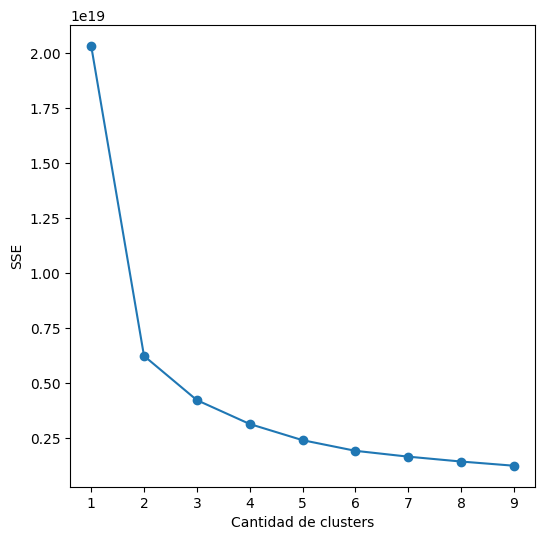

In [ ]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_numeric)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Observamos que el mayor quiebre de la pendiente se produce a los 2 clusters y lentamente se quiebra cada vez menos a medida que aumente la cantidad de clusters. Viendo el grafico utilizaremos 5 clusters ya que a partir de esta cantidad el quiebre es negligente.

### c - Evaluar la calidad de los grupos formados realizando un análisis de Silhouette

### Análisis de Silhouette

El Índice de Silueta indica si existen o no estructuras en los datos.

A continuación graficamos el índice de silueta variando la cantidad de clusters de 2 a 5 

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_numeric)

    score = silhouette_score (df_numeric, preds)
    print ("For n_clusters = " + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters = 2 silhouette score is 0.5882597708861601
For n_clusters = 3 silhouette score is 0.4910561552793787
For n_clusters = 4 silhouette score is 0.5115533905766104
For n_clusters = 5 silhouette score is 0.45664785283096115


Evaluamos la calidad de los grupos formados utilizando el metodo de Silhoutte

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


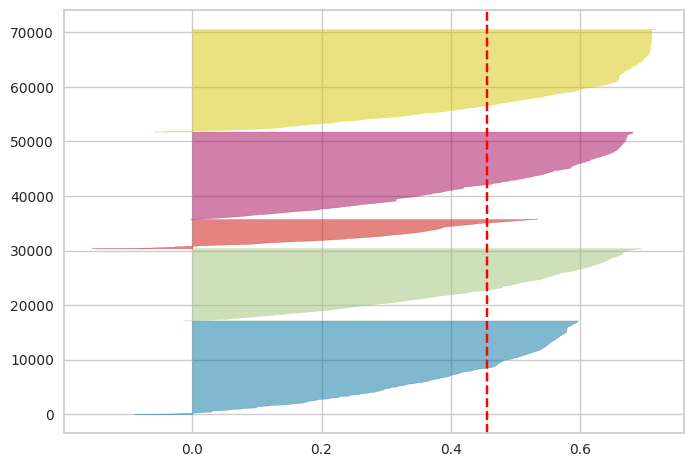

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(5, random_state=0)

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_numeric)
plt.show()

### Algoritmo de K-Means

1. El usuario decide la cantidad de grupos

undefined. K-Means elige al azar K centroides

undefined. Decide qué grupos están más cerca de cada centroide. Esos puntos forman un grupo

undefined. K-Means recalcula los centroides al centro de cada grupo.

undefined. K-Means vuelve a reasignar los puntos usando los nuevos centroides. Calcula nuevos grupos

undefined. K-Means repite punto 4. y 5. hasta que los puntos no combian de grupo.

In [ ]:
model.fit(df_numeric)
clusters = model.predict(df_numeric)

### d - Realizar un análisis de cada grupo intentando entender en función de qué
 características fueron formados

Para entender la relación que hay en cada grupo, lo visualizamos en un gráfico:

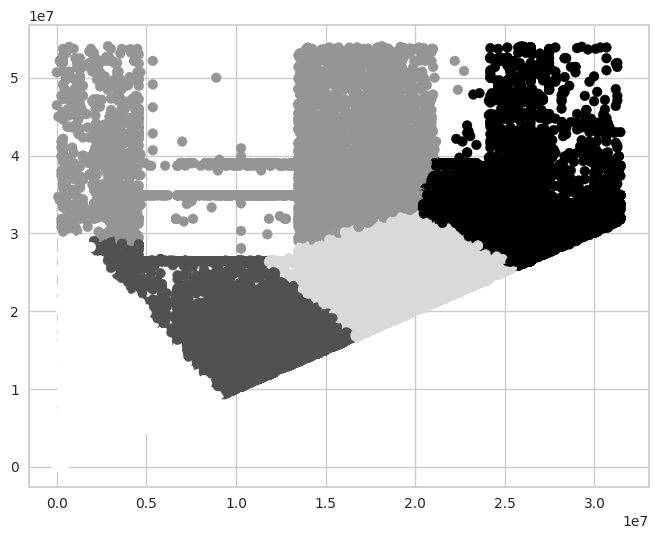

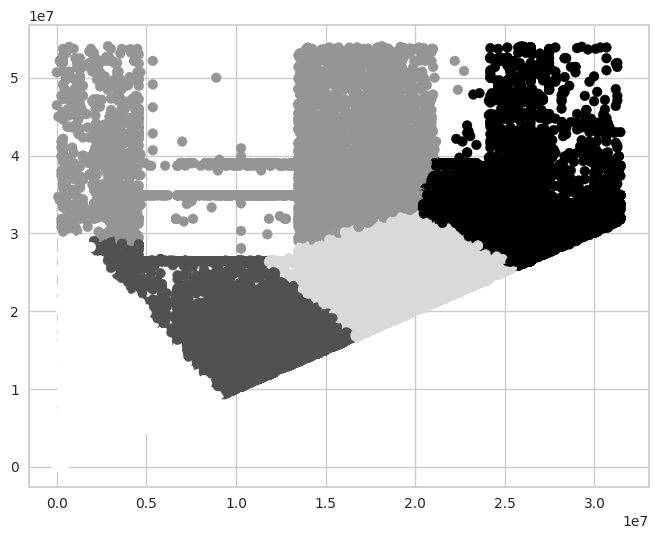

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_numeric.iloc[:,0].values,df_numeric.iloc[:,1].values, c=model.labels_.astype(float))

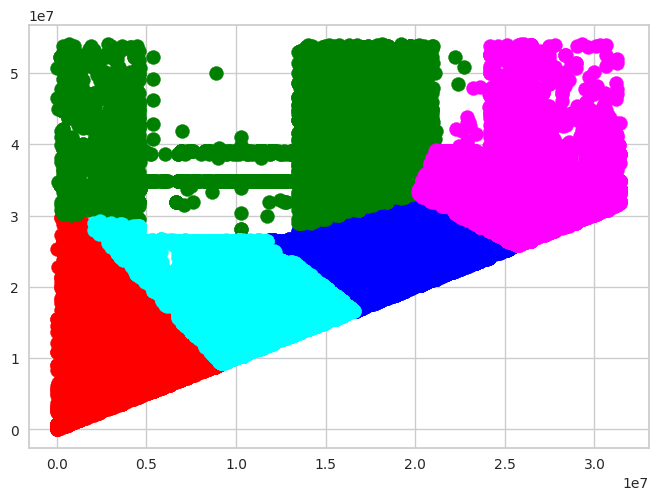

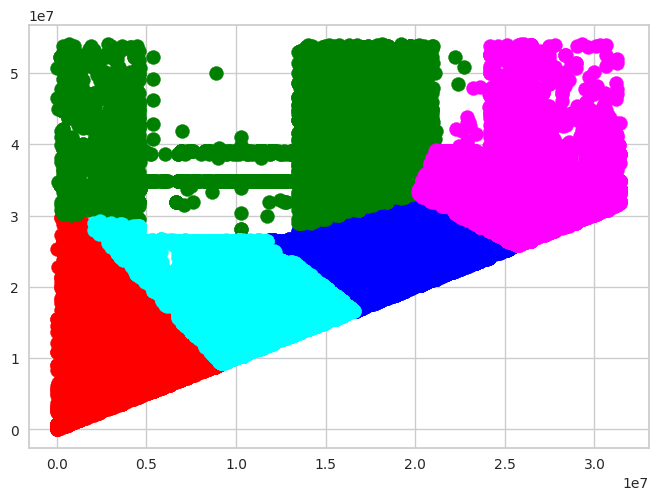

In [ ]:
plt.scatter(df_numeric.iloc[clusters==0, 0], df_numeric.iloc[clusters==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_numeric.iloc[clusters==1, 0], df_numeric.iloc[clusters==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_numeric.iloc[clusters==2, 0], df_numeric.iloc[clusters==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(df_numeric.iloc[clusters==3, 0], df_numeric.iloc[clusters==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(df_numeric.iloc[clusters==4, 0], df_numeric.iloc[clusters==4, 1], s=100, c='magenta', label ='Cluster 5')

Analizamos cada cluster por separado para entender en función de qué
 características fueron formados:

1. Primer Cluster

In [ ]:
df_numeric.iloc[clusters==0, :]

start_date    end_date  created_on    latitud   longitud  \
228948   5702400.0  13392000.0   5702400.0 -34.577033 -58.423367   
361800   1296000.0  24278400.0   1296000.0 -34.580210 -58.412815   
212313   6912000.0  10454400.0   6912000.0 -34.604367 -58.404872   
178187   6998400.0   7257600.0   6998400.0 -34.609449 -58.393884   
377901   6393600.0   9590400.0   6393600.0 -34.588119 -58.388227   
...            ...         ...         ...        ...        ...   
60092    2073600.0  25574400.0   2073600.0 -34.625013 -58.443328   
355717   7689600.0   8985600.0   7689600.0 -34.619137 -58.453847   
212476   6912000.0   8121600.0   6912000.0 -34.587105 -58.431588   
264371   4838400.0   5443200.0   4838400.0 -34.615136 -58.394638   
397579   3715200.0   5097600.0   3715200.0 -34.581845 -58.405495   

        property_rooms  property_bedrooms  property_surface_total  \
228948        1.000000           1.000000               49.000000   
361800        1.000000           2.000000              112.256728   
212313        3.000000           2.000000               60.000000   
178187        2.000000           1.000000               29.000000   
377901        3.000000           2.000000               87.000000   
...                ...                ...                     ...   
60092         3.000000           2.000000               70.000000   
355717        1.000000           1.000000               33.000000   
212476        1.000000           2.016427               29.000000   
264371        1.000000           2.016427               22.000000   
397579        2.825976           1.000000               37.000000   

        property_surface_covered  property_price  ...  \
228948                      44.0        160000.0  ...   
361800                      78.0        290000.0  ...   
212313                      50.0        105000.0  ...   
178187                      29.0         55000.0  ...   
377901                      87.0        430000.0  ...   
...                          ...             ...  ...   
60092                       66.0        235000.0  ...   
355717                      30.0         69000.0  ...   
212476                      26.0         82000.0  ...   
264371                      22.0         42000.0  ...   
397579                      36.0         98000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
228948                          0                        0   
361800                          0                        0   
212313                          0                        0   
178187                          0                        0   
377901                          0                        0   
...                           ...                      ...   
60092                           0                        0   
355717                          0                        0   
212476                          0                        0   
264371                          0                        0   
397579                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
228948                           0                              0   
361800                           0                              0   
212313                           0                              0   
178187                           0                              0   
377901                           0                              0   
...                            ...                            ...   
60092                            0                              0   
355717                           0                              0   
212476                           0                              0   
264371                           0                              0   
397579                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
228948                        0       

start_date    end_date  created_on    latitud   longitud  \
228948   5702400.0  13392000.0   5702400.0 -34.577033 -58.423367   
361800   1296000.0  24278400.0   1296000.0 -34.580210 -58.412815   
212313   6912000.0  10454400.0   6912000.0 -34.604367 -58.404872   
178187   6998400.0   7257600.0   6998400.0 -34.609449 -58.393884   
377901   6393600.0   9590400.0   6393600.0 -34.588119 -58.388227   
...            ...         ...         ...        ...        ...   
60092    2073600.0  25574400.0   2073600.0 -34.625013 -58.443328   
355717   7689600.0   8985600.0   7689600.0 -34.619137 -58.453847   
212476   6912000.0   8121600.0   6912000.0 -34.587105 -58.431588   
264371   4838400.0   5443200.0   4838400.0 -34.615136 -58.394638   
397579   3715200.0   5097600.0   3715200.0 -34.581845 -58.405495   

        property_rooms  property_bedrooms  property_surface_total  \
228948        1.000000           1.000000               49.000000   
361800        1.000000           2.000000              112.256728   
212313        3.000000           2.000000               60.000000   
178187        2.000000           1.000000               29.000000   
377901        3.000000           2.000000               87.000000   
...                ...                ...                     ...   
60092         3.000000           2.000000               70.000000   
355717        1.000000           1.000000               33.000000   
212476        1.000000           2.016427               29.000000   
264371        1.000000           2.016427               22.000000   
397579        2.825976           1.000000               37.000000   

        property_surface_covered  property_price  ...  \
228948                      44.0        160000.0  ...   
361800                      78.0        290000.0  ...   
212313                      50.0        105000.0  ...   
178187                      29.0         55000.0  ...   
377901                      87.0        430000.0  ...   
...                          ...             ...  ...   
60092                       66.0        235000.0  ...   
355717                      30.0         69000.0  ...   
212476                      26.0         82000.0  ...   
264371                      22.0         42000.0  ...   
397579                      36.0         98000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
228948                          0                        0   
361800                          0                        0   
212313                          0                        0   
178187                          0                        0   
377901                          0                        0   
...                           ...                      ...   
60092                           0                        0   
355717                          0                        0   
212476                          0                        0   
264371                          0                        0   
397579                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
228948                           0                              0   
361800                           0                              0   
212313                           0                              0   
178187                           0                              0   
377901                           0                              0   
...                            ...                            ...   
60092                            0                              0   
355717                           0                              0   
212476                           0                              0   
264371                           0                              0   
397579                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
228948                        0       

2. Segundo Cluster

In [ ]:
df_numeric.iloc[clusters==1, :]

start_date    end_date  created_on    latitud   longitud  \
187633  13392000.0  23500800.0  13392000.0 -34.610446 -58.408441   
163967  13564800.0  24192000.0  13564800.0 -34.579829 -58.433008   
266218  21081600.0  21081600.0  21081600.0 -34.581770 -58.422489   
76572   17020800.0  17107200.0  17020800.0 -34.590854 -58.415855   
282339  22291200.0  22550400.0  22291200.0 -34.565047 -58.434799   
...            ...         ...         ...        ...        ...   
254931  19958400.0  21081600.0  19958400.0 -34.613078 -58.435614   
347521  23500800.0  28425600.0  23500800.0 -34.574255 -58.460924   
160556  16761600.0  17280000.0  16761600.0 -34.640558 -58.486536   
415279  21600000.0  23414400.0  21600000.0 -34.552470 -58.456270   
217366  21254400.0  23155200.0  21254400.0 -34.568071 -58.458146   

        property_rooms  property_bedrooms  property_surface_total  \
187633             1.0           1.000000                    33.0   
163967             1.0           2.016427                    41.0   
266218             4.0           3.000000                   128.0   
76572              2.0           1.000000                    33.0   
282339             3.0           2.000000                    85.0   
...                ...                ...                     ...   
254931             5.0           4.000000                   168.0   
347521             2.0           1.000000                    55.0   
160556             3.0           2.000000                    75.0   
415279             2.0           1.000000                    51.0   
217366             2.0           1.000000                    52.0   

        property_surface_covered  property_price  ...  \
187633                      31.0         44900.0  ...   
163967                      30.0         99500.0  ...   
266218                     123.0        316242.0  ...   
76572                       30.0         95000.0  ...   
282339                      79.0        249000.0  ...   
...                          ...             ...  ...   
254931                     159.0        198000.0  ...   
347521                      55.0        119000.0  ...   
160556                      69.0         99500.0  ...   
415279                      51.0        146000.0  ...   
217366                      45.0        135000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
187633                          0                        0   
163967                          0                        0   
266218                          0                        0   
76572                           0                        0   
282339                          0                        0   
...                           ...                      ...   
254931                          0                        0   
347521                          0                        0   
160556                          0                        0   
415279                          0                        0   
217366                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
187633                           0                              0   
163967                           0                              0   
266218                           0                              0   
76572                            0                              0   
282339                           0                              0   
...                            ...                            ...   
254931                           0                              0   
347521                           0                              0   
160556                           0                              0   
415279                           0                              0   
217366                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
187633                        0       

start_date    end_date  created_on    latitud   longitud  \
187633  13392000.0  23500800.0  13392000.0 -34.610446 -58.408441   
163967  13564800.0  24192000.0  13564800.0 -34.579829 -58.433008   
266218  21081600.0  21081600.0  21081600.0 -34.581770 -58.422489   
76572   17020800.0  17107200.0  17020800.0 -34.590854 -58.415855   
282339  22291200.0  22550400.0  22291200.0 -34.565047 -58.434799   
...            ...         ...         ...        ...        ...   
254931  19958400.0  21081600.0  19958400.0 -34.613078 -58.435614   
347521  23500800.0  28425600.0  23500800.0 -34.574255 -58.460924   
160556  16761600.0  17280000.0  16761600.0 -34.640558 -58.486536   
415279  21600000.0  23414400.0  21600000.0 -34.552470 -58.456270   
217366  21254400.0  23155200.0  21254400.0 -34.568071 -58.458146   

        property_rooms  property_bedrooms  property_surface_total  \
187633             1.0           1.000000                    33.0   
163967             1.0           2.016427                    41.0   
266218             4.0           3.000000                   128.0   
76572              2.0           1.000000                    33.0   
282339             3.0           2.000000                    85.0   
...                ...                ...                     ...   
254931             5.0           4.000000                   168.0   
347521             2.0           1.000000                    55.0   
160556             3.0           2.000000                    75.0   
415279             2.0           1.000000                    51.0   
217366             2.0           1.000000                    52.0   

        property_surface_covered  property_price  ...  \
187633                      31.0         44900.0  ...   
163967                      30.0         99500.0  ...   
266218                     123.0        316242.0  ...   
76572                       30.0         95000.0  ...   
282339                      79.0        249000.0  ...   
...                          ...             ...  ...   
254931                     159.0        198000.0  ...   
347521                      55.0        119000.0  ...   
160556                      69.0         99500.0  ...   
415279                      51.0        146000.0  ...   
217366                      45.0        135000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
187633                          0                        0   
163967                          0                        0   
266218                          0                        0   
76572                           0                        0   
282339                          0                        0   
...                           ...                      ...   
254931                          0                        0   
347521                          0                        0   
160556                          0                        0   
415279                          0                        0   
217366                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
187633                           0                              0   
163967                           0                              0   
266218                           0                              0   
76572                            0                              0   
282339                           0                              0   
...                            ...                            ...   
254931                           0                              0   
347521                           0                              0   
160556                           0                              0   
415279                           0                              0   
217366                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
187633                        0       

3. Tercer Cluster

In [ ]:
df_numeric.iloc[clusters==2, :]

start_date    end_date  created_on    latitud   longitud  \
251741  14515200.0  34905600.0  14515200.0 -34.616469 -58.370769   
360651   1296000.0  33350400.0   1296000.0 -34.643060 -58.361352   
26134   15033600.0  51062400.0  15033600.0 -34.593049 -58.379873   
155007   2851200.0  43113600.0   2851200.0 -34.591166 -58.450646   
439706  17280000.0  33436800.0  17280000.0 -34.601138 -58.459027   
...            ...         ...         ...        ...        ...   
147746  19872000.0  33782400.0  19872000.0 -34.591166 -58.450646   
114221  13737600.0  29376000.0  13737600.0 -34.610095 -58.503822   
147647  19872000.0  33782400.0  19872000.0 -34.566348 -58.437582   
271050  16675200.0  36806400.0  16675200.0 -34.632545 -58.475753   
196298  17798400.0  35769600.0  17798400.0 -34.566632 -58.438352   

        property_rooms  property_bedrooms  property_surface_total  \
251741             4.0           4.000000                   257.0   
360651             6.0           4.000000                   199.0   
26134              3.0           2.000000                   120.0   
155007             1.0           2.016427                    47.0   
439706             3.0           2.000000                    41.0   
...                ...                ...                     ...   
147746             2.0           1.000000                    71.0   
114221             2.0           1.000000                    43.0   
147647             4.0           3.000000                   133.0   
271050             5.0           4.000000                   194.0   
196298             2.0           1.000000                    43.0   

        property_surface_covered  property_price  ...  \
251741                     178.0        249900.0  ...   
360651                     157.0        160000.0  ...   
26134                      120.0        390000.0  ...   
155007                      32.0         66780.0  ...   
439706                      41.0         75000.0  ...   
...                          ...             ...  ...   
147746                      57.0        160000.0  ...   
114221                      28.0        107000.0  ...   
147647                     130.0        340000.0  ...   
271050                     106.0        245000.0  ...   
196298                      43.0         93000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
251741                          0                        0   
360651                          0                        0   
26134                           0                        0   
155007                          0                        0   
439706                          0                        0   
...                           ...                      ...   
147746                          0                        0   
114221                          0                        0   
147647                          0                        0   
271050                          0                        0   
196298                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
251741                           0                              0   
360651                           0                              0   
26134                            0                              0   
155007                           0                              0   
439706                           0                              0   
...                            ...                            ...   
147746                           0                              0   
114221                           0                              0   
147647                           0                              0   
271050                           0                              0   
196298                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
251741                        0       

start_date    end_date  created_on    latitud   longitud  \
251741  14515200.0  34905600.0  14515200.0 -34.616469 -58.370769   
360651   1296000.0  33350400.0   1296000.0 -34.643060 -58.361352   
26134   15033600.0  51062400.0  15033600.0 -34.593049 -58.379873   
155007   2851200.0  43113600.0   2851200.0 -34.591166 -58.450646   
439706  17280000.0  33436800.0  17280000.0 -34.601138 -58.459027   
...            ...         ...         ...        ...        ...   
147746  19872000.0  33782400.0  19872000.0 -34.591166 -58.450646   
114221  13737600.0  29376000.0  13737600.0 -34.610095 -58.503822   
147647  19872000.0  33782400.0  19872000.0 -34.566348 -58.437582   
271050  16675200.0  36806400.0  16675200.0 -34.632545 -58.475753   
196298  17798400.0  35769600.0  17798400.0 -34.566632 -58.438352   

        property_rooms  property_bedrooms  property_surface_total  \
251741             4.0           4.000000                   257.0   
360651             6.0           4.000000                   199.0   
26134              3.0           2.000000                   120.0   
155007             1.0           2.016427                    47.0   
439706             3.0           2.000000                    41.0   
...                ...                ...                     ...   
147746             2.0           1.000000                    71.0   
114221             2.0           1.000000                    43.0   
147647             4.0           3.000000                   133.0   
271050             5.0           4.000000                   194.0   
196298             2.0           1.000000                    43.0   

        property_surface_covered  property_price  ...  \
251741                     178.0        249900.0  ...   
360651                     157.0        160000.0  ...   
26134                      120.0        390000.0  ...   
155007                      32.0         66780.0  ...   
439706                      41.0         75000.0  ...   
...                          ...             ...  ...   
147746                      57.0        160000.0  ...   
114221                      28.0        107000.0  ...   
147647                     130.0        340000.0  ...   
271050                     106.0        245000.0  ...   
196298                      43.0         93000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
251741                          0                        0   
360651                          0                        0   
26134                           0                        0   
155007                          0                        0   
439706                          0                        0   
...                           ...                      ...   
147746                          0                        0   
114221                          0                        0   
147647                          0                        0   
271050                          0                        0   
196298                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
251741                           0                              0   
360651                           0                              0   
26134                            0                              0   
155007                           0                              0   
439706                           0                              0   
...                            ...                            ...   
147746                           0                              0   
114221                           0                              0   
147647                           0                              0   
271050                           0                              0   
196298                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
251741                        0       

4. Cuarto Cluster

In [ ]:
df_numeric.iloc[clusters==3, :]

start_date    end_date  created_on    latitud   longitud  \
445441  12009600.0  13392000.0  12009600.0 -34.591166 -58.450646   
286235  14342400.0  19353600.0  14342400.0 -34.611728 -58.388853   
183767   9244800.0  13392000.0   9244800.0 -34.577227 -58.404563   
24269   10540800.0  13392000.0  10540800.0 -34.605064 -58.411524   
52130   11664000.0  11836800.0  11664000.0 -34.603217 -58.440263   
...            ...         ...         ...        ...        ...   
96174   15724800.0  15811200.0  15724800.0 -34.622861 -58.460870   
103852  12700800.0  23414400.0  12700800.0 -34.609396 -58.448392   
164293  13564800.0  18489600.0  13564800.0 -34.616987 -58.445827   
149099  11318400.0  13392000.0  11318400.0 -34.559379 -58.480078   
438863   9676800.0  13392000.0   9676800.0 -34.561937 -58.453636   

        property_rooms  property_bedrooms  property_surface_total  \
445441             3.0                2.0               72.000000   
286235             3.0                2.0               65.000000   
183767             3.0                2.0              112.256728   
24269              2.0                1.0               35.000000   
52130              2.0                1.0               43.000000   
...                ...                ...                     ...   
96174              4.0                3.0              117.000000   
103852             2.0                1.0               42.000000   
164293             4.0                3.0               96.000000   
149099             2.0                1.0               58.000000   
438863             2.0                1.0               50.000000   

        property_surface_covered  property_price  ...  \
445441                 65.000000        198000.0  ...   
286235                 54.000000         62000.0  ...   
183767                133.000000        380000.0  ...   
24269                  35.000000         67500.0  ...   
52130                  38.000000         72000.0  ...   
...                          ...             ...  ...   
96174                 102.000000        230000.0  ...   
103852                 38.000000        109000.0  ...   
164293                 87.000000        290000.0  ...   
149099                 51.000000        160000.0  ...   
438863                 90.303995        175000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
445441                          0                        0   
286235                          0                        0   
183767                          0                        0   
24269                           0                        0   
52130                           0                        0   
...                           ...                      ...   
96174                           0                        0   
103852                          0                        0   
164293                          0                        0   
149099                          0                        0   
438863                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
445441                           0                              0   
286235                           0                              0   
183767                           0                              0   
24269                            0                              0   
52130                            0                              0   
...                            ...                            ...   
96174                            0                              0   
103852                           0                              0   
164293                           0                              0   
149099                           0                              0   
438863                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
445441                        0       

start_date    end_date  created_on    latitud   longitud  \
445441  12009600.0  13392000.0  12009600.0 -34.591166 -58.450646   
286235  14342400.0  19353600.0  14342400.0 -34.611728 -58.388853   
183767   9244800.0  13392000.0   9244800.0 -34.577227 -58.404563   
24269   10540800.0  13392000.0  10540800.0 -34.605064 -58.411524   
52130   11664000.0  11836800.0  11664000.0 -34.603217 -58.440263   
...            ...         ...         ...        ...        ...   
96174   15724800.0  15811200.0  15724800.0 -34.622861 -58.460870   
103852  12700800.0  23414400.0  12700800.0 -34.609396 -58.448392   
164293  13564800.0  18489600.0  13564800.0 -34.616987 -58.445827   
149099  11318400.0  13392000.0  11318400.0 -34.559379 -58.480078   
438863   9676800.0  13392000.0   9676800.0 -34.561937 -58.453636   

        property_rooms  property_bedrooms  property_surface_total  \
445441             3.0                2.0               72.000000   
286235             3.0                2.0               65.000000   
183767             3.0                2.0              112.256728   
24269              2.0                1.0               35.000000   
52130              2.0                1.0               43.000000   
...                ...                ...                     ...   
96174              4.0                3.0              117.000000   
103852             2.0                1.0               42.000000   
164293             4.0                3.0               96.000000   
149099             2.0                1.0               58.000000   
438863             2.0                1.0               50.000000   

        property_surface_covered  property_price  ...  \
445441                 65.000000        198000.0  ...   
286235                 54.000000         62000.0  ...   
183767                133.000000        380000.0  ...   
24269                  35.000000         67500.0  ...   
52130                  38.000000         72000.0  ...   
...                          ...             ...  ...   
96174                 102.000000        230000.0  ...   
103852                 38.000000        109000.0  ...   
164293                 87.000000        290000.0  ...   
149099                 51.000000        160000.0  ...   
438863                 90.303995        175000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
445441                          0                        0   
286235                          0                        0   
183767                          0                        0   
24269                           0                        0   
52130                           0                        0   
...                           ...                      ...   
96174                           0                        0   
103852                          0                        0   
164293                          0                        0   
149099                          0                        0   
438863                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
445441                           0                              0   
286235                           0                              0   
183767                           0                              0   
24269                            0                              0   
52130                            0                              0   
...                            ...                            ...   
96174                            0                              0   
103852                           0                              0   
164293                           0                              0   
149099                           0                              0   
438863                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
445441                        0       

5. Quinto Cluster

In [ ]:
df_numeric.iloc[clusters==4, :]

start_date    end_date  created_on    latitud   longitud  \
256070  26438400.0  34300800.0  26438400.0 -34.566536 -58.479638   
27438   29030400.0  33782400.0  29030400.0 -34.645625 -58.459408   
211207  27561600.0  27734400.0  27561600.0 -34.591166 -58.450646   
153179  29548800.0  30153600.0  29548800.0 -34.582107 -58.448826   
53530   22809600.0  37324800.0  22809600.0 -34.581356 -58.433269   
...            ...         ...         ...        ...        ...   
255850  26438400.0  27216000.0  26438400.0 -34.544466 -58.471032   
54005   22809600.0  34905600.0  22809600.0 -34.600961 -58.376123   
172381  30499200.0  34905600.0  30499200.0 -34.573918 -58.439126   
215681  27648000.0  33782400.0  27648000.0 -34.602083 -58.363912   
356023  27734400.0  33782400.0  27734400.0 -34.604955 -58.422891   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0           1.000000                    65.0   
27438              1.0           2.016427                    29.0   
211207             2.0           1.000000                    41.0   
153179             1.0           1.000000                    36.0   
53530              2.0           1.000000                    70.0   
...                ...                ...                     ...   
255850             1.0           2.016427                    60.0   
54005              2.0           1.000000                    55.0   
172381             2.0           1.000000                    44.0   
215681             3.0           2.000000                   145.0   
356023             3.0           2.000000                   123.0   

        property_surface_covered  property_price  ...  \
256070                      53.0        198000.0  ...   
27438                       29.0         63000.0  ...   
211207                      35.0         93000.0  ...   
153179                      31.0         83789.0  ...   
53530                       66.0        205000.0  ...   
...                          ...             ...  ...   
255850                      29.0        121333.0  ...   
54005                       55.0         91000.0  ...   
172381                      35.0         77500.0  ...   
215681                     111.0        650000.0  ...   
356023                      71.0        139000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
256070                          0                        0   
27438                           0                        0   
211207                          0                        0   
153179                          0                        0   
53530                           0                        0   
...                           ...                      ...   
255850                          0                        0   
54005                           0                        0   
172381                          0                        0   
215681                          0                        0   
356023                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
256070                           0                              0   
27438                            0                              0   
211207                           0                              0   
153179                           0                              0   
53530                            0                              0   
...                            ...                            ...   
255850                           0                              0   
54005                            0                              0   
172381                           0                              0   
215681                           0                              0   
356023                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
256070                        0       

start_date    end_date  created_on    latitud   longitud  \
256070  26438400.0  34300800.0  26438400.0 -34.566536 -58.479638   
27438   29030400.0  33782400.0  29030400.0 -34.645625 -58.459408   
211207  27561600.0  27734400.0  27561600.0 -34.591166 -58.450646   
153179  29548800.0  30153600.0  29548800.0 -34.582107 -58.448826   
53530   22809600.0  37324800.0  22809600.0 -34.581356 -58.433269   
...            ...         ...         ...        ...        ...   
255850  26438400.0  27216000.0  26438400.0 -34.544466 -58.471032   
54005   22809600.0  34905600.0  22809600.0 -34.600961 -58.376123   
172381  30499200.0  34905600.0  30499200.0 -34.573918 -58.439126   
215681  27648000.0  33782400.0  27648000.0 -34.602083 -58.363912   
356023  27734400.0  33782400.0  27734400.0 -34.604955 -58.422891   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0           1.000000                    65.0   
27438              1.0           2.016427                    29.0   
211207             2.0           1.000000                    41.0   
153179             1.0           1.000000                    36.0   
53530              2.0           1.000000                    70.0   
...                ...                ...                     ...   
255850             1.0           2.016427                    60.0   
54005              2.0           1.000000                    55.0   
172381             2.0           1.000000                    44.0   
215681             3.0           2.000000                   145.0   
356023             3.0           2.000000                   123.0   

        property_surface_covered  property_price  ...  \
256070                      53.0        198000.0  ...   
27438                       29.0         63000.0  ...   
211207                      35.0         93000.0  ...   
153179                      31.0         83789.0  ...   
53530                       66.0        205000.0  ...   
...                          ...             ...  ...   
255850                      29.0        121333.0  ...   
54005                       55.0         91000.0  ...   
172381                      35.0         77500.0  ...   
215681                     111.0        650000.0  ...   
356023                      71.0        139000.0  ...   

        neighborhood_Villa Lugano  neighborhood_Villa Luro  \
256070                          0                        0   
27438                           0                        0   
211207                          0                        0   
153179                          0                        0   
53530                           0                        0   
...                           ...                      ...   
255850                          0                        0   
54005                           0                        0   
172381                          0                        0   
215681                          0                        0   
356023                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
256070                           0                              0   
27438                            0                              0   
211207                           0                              0   
153179                           0                              0   
53530                            0                              0   
...                            ...                            ...   
255850                           0                              0   
54005                            0                              0   
172381                           0                              0   
215681                           0                              0   
356023                           0                              0   

        neighborhood_Villa Real  neighborhood_Villa Riachuelo  \
256070                        0       

### e - Graficar sobre un mapa de CABA los avisos coloreados segun el grupo al que pertenecen

In [ ]:
color_map = {
    0: 'magenta',
    1: 'cyan',
    2: 'green',
    3: 'blue',
    4: 'red'
}

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

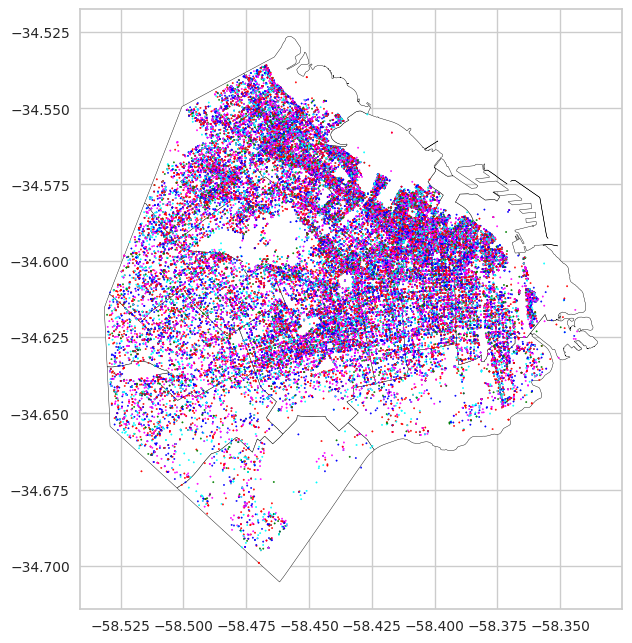

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


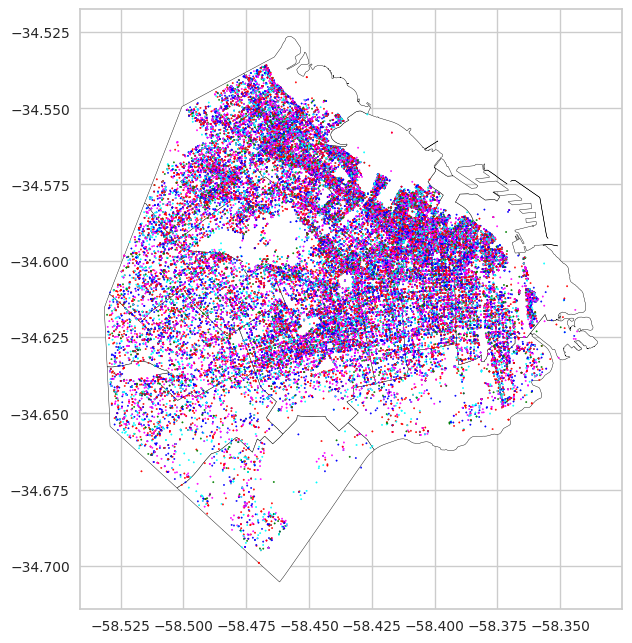

In [ ]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))

df = df_numeric[(df_numeric['latitud'] < -34) & (df_numeric['latitud'] > -35) & (df_numeric['longitud'] > -59)]

# Reemplazar este dataframe por el nuestro
# Aca solo tendriamos que cambiar lat y long para que usen los del dataframe
# Lo que hace aca es convertir latitude y longitude en puntos
gdf = gpd.GeoDataFrame(df.drop(['latitud', 'longitud'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(df.longitud, df.latitud)])
world = gpd.read_file('mapa_caba/mapa.shp')


base = world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', markersize=1, c=[color_map[label] for label in model.labels_])

plt.show()

### Análisis para 3 grupos

A continuación se realizará el mismo analisis pero para solamente para 3 grupos.

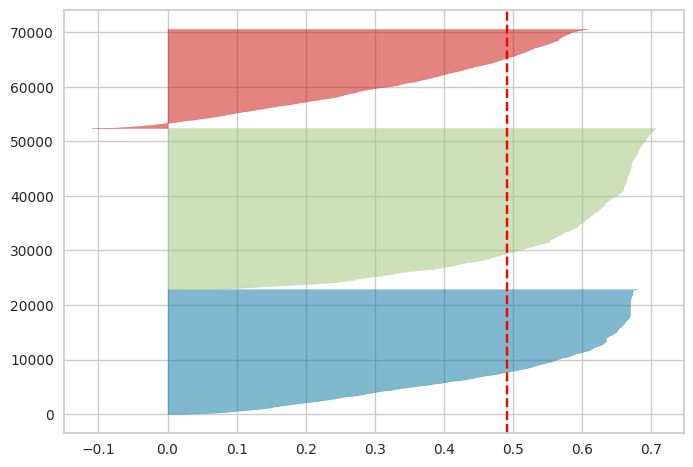

KeyboardInterrupt: 

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model_3 = KMeans(3, random_state=0)

# Volvemos a visualizar el gráfico de silueta
visualizer_3 = SilhouetteVisualizer(model_3, colors='yellowbrick')
visualizer_3.fit(df_numeric)
plt.show()

In [ ]:
df_test_numeric = df_numeric.copy()
df_test_numeric = df_test_numeric.drop(columns=['start_date', 'end_date', 'created_on'])

In [ ]:
model_3.fit(df_test_numeric)
clusters_3 = model_3.predict(df_test_numeric)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

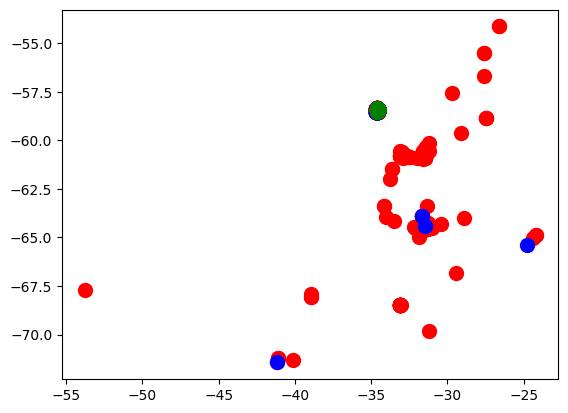

In [ ]:
plt.scatter(df_test_numeric.iloc[clusters_3==0, 0], df_test_numeric.iloc[clusters_3==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_test_numeric.iloc[clusters_3==1, 0], df_test_numeric.iloc[clusters_3==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_test_numeric.iloc[clusters_3==2, 0], df_test_numeric.iloc[clusters_3==2, 1], s=100, c='green', label ='Cluster 3')

Volvemos a analizamos cada cluster por separado:

1. Primer Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==0, :]

latitud   longitud  property_rooms  property_bedrooms  \
256070 -34.566536 -58.479638             2.0           1.000000   
27438  -34.645625 -58.459408             1.0           2.016427   
211207 -34.591166 -58.450646             2.0           1.000000   
228948 -34.577033 -58.423367             1.0           1.000000   
361800 -34.580210 -58.412815             1.0           2.000000   
...           ...        ...             ...                ...   
415279 -34.552470 -58.456270             2.0           1.000000   
149099 -34.559379 -58.480078             2.0           1.000000   
217366 -34.568071 -58.458146             2.0           1.000000   
356023 -34.604955 -58.422891             3.0           2.000000   
438863 -34.561937 -58.453636             2.0           1.000000   

        property_surface_total  property_surface_covered  property_price  \
256070               65.000000                 53.000000        198000.0   
27438                29.000000                 29.000000         63000.0   
211207               41.000000                 35.000000         93000.0   
228948               49.000000                 44.000000        160000.0   
361800              112.256728                 78.000000        290000.0   
...                        ...                       ...             ...   
415279               51.000000                 51.000000        146000.0   
149099               58.000000                 51.000000        160000.0   
217366               52.000000                 45.000000        135000.0   
356023              123.000000                 71.000000        139000.0   
438863               50.000000                 90.303995        175000.0   

        property_type_Departamento  property_type_PH  neighborhood_Agronomía  \
256070                           1                 0                       0   
27438                            1                 0                       0   
211207                           1                 0                       0   
228948                           1                 0                       0   
361800                           1                 0                       0   
...                            ...               ...                     ...   
415279                           1                 0                       0   
149099                           1                 0                       0   
217366                           1                 0                       0   
356023                           0                 1                       0   
438863                           1                 0                       0   

        ...  neighborhood_Villa Lugano  neighborhood_Villa Luro  \
256070  ...                          0                        0   
27438   ...                          0                        0   
211207  ...                          0                        0   
228948  ...                          0                        0   
361800  ...                          0                        0   
...     ...                        ...                      ...   
415279  ...                          0                        0   
149099  ...                          0                        0   
217366  ...                          0                        0   
356023  ...                          0                        0   
438863  ...                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
256070                           0                              0   
27438                            0                              0   
211207                           0                              0   
228948                           0                              0   
361800                           0                              0   
...                            ...                            ...   
415279                           0         

2. Segundo Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==1, :]

latitud   longitud  property_rooms  property_bedrooms  \
318910 -34.573333 -58.421634             3.0                2.0   
307877 -34.591166 -58.450646             5.0                5.0   
229171 -34.592048 -58.392022             4.0                3.0   
274591 -34.582185 -58.401540             5.0                3.0   
45841  -34.561566 -58.464539             5.0                3.0   
...           ...        ...             ...                ...   
334298 -34.590131 -58.384749             5.0                2.0   
73549  -34.551935 -58.442412             4.0                3.0   
141135 -34.631387 -58.429794             6.0                5.0   
94498  -34.564240 -58.450937             5.0                3.0   
215681 -34.602083 -58.363912             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
318910                   110.0                     100.0        550000.0   
307877                   192.0                     182.0        585000.0   
229171                   182.0                     182.0        495000.0   
274591                   194.0                     194.0        780000.0   
45841                    177.0                     111.0        490000.0   
...                        ...                       ...             ...   
334298                   325.0                     309.0       1750000.0   
73549                    138.0                     127.0        695000.0   
141135                   246.0                     159.0        479900.0   
94498                    230.0                     215.0        565000.0   
215681                   145.0                     111.0        650000.0   

        property_type_Departamento  property_type_PH  neighborhood_Agronomía  \
318910                           1                 0                       0   
307877                           1                 0                       0   
229171                           1                 0                       0   
274591                           1                 0                       0   
45841                            1                 0                       0   
...                            ...               ...                     ...   
334298                           1                 0                       0   
73549                            1                 0                       0   
141135                           0                 1                       0   
94498                            1                 0                       0   
215681                           1                 0                       0   

        ...  neighborhood_Villa Lugano  neighborhood_Villa Luro  \
318910  ...                          0                        0   
307877  ...                          0                        0   
229171  ...                          0                        0   
274591  ...                          0                        0   
45841   ...                          0                        0   
...     ...                        ...                      ...   
334298  ...                          0                        0   
73549   ...                          0                        0   
141135  ...                          0                        0   
94498   ...                          0                        0   
215681  ...                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
318910                           0                              0   
307877                           0                              0   
229171                           0                              0   
274591                           0                              0   
45841                            0                              0   
...                            ...                            ...   
334298                           0         

3. Tercer Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==2, :]

latitud   longitud  property_rooms  property_bedrooms  \
358714 -34.590923 -58.384214        9.000000           4.000000   
134312 -34.579205 -58.398950        2.825976           4.000000   
196891 -34.577585 -58.400554        2.825976           2.016427   
158371 -34.574864 -58.421311        7.000000           4.000000   
306543 -34.590923 -58.384214        7.000000           3.000000   
...           ...        ...             ...                ...   
365464 -34.567172 -58.430634        5.000000           4.000000   
129764 -34.571179 -58.431863        7.000000           4.000000   
103648 -34.566206 -58.444766        5.000000           3.000000   
287335 -34.565859 -58.444674        5.000000           4.000000   
70107  -34.588758 -58.388796       10.000000           5.000000   

        property_surface_total  property_surface_covered  property_price  \
358714              668.000000                     668.0       5000000.0   
134312             1000.000000                     990.0       4500000.0   
196891              112.256728                     360.0       3500000.0   
158371              400.000000                     400.0       3500000.0   
306543              318.000000                     318.0       1900000.0   
...                        ...                       ...             ...   
365464              400.000000                     400.0       4000000.0   
129764              425.000000                     400.0       2100000.0   
103648              562.000000                     320.0       2500000.0   
287335              562.000000                     300.0       2290000.0   
70107               477.000000                     400.0       1800000.0   

        property_type_Departamento  property_type_PH  neighborhood_Agronomía  \
358714                           1                 0                       0   
134312                           0                 0                       0   
196891                           0                 0                       0   
158371                           1                 0                       0   
306543                           1                 0                       0   
...                            ...               ...                     ...   
365464                           1                 0                       0   
129764                           1                 0                       0   
103648                           1                 0                       0   
287335                           1                 0                       0   
70107                            1                 0                       0   

        ...  neighborhood_Villa Lugano  neighborhood_Villa Luro  \
358714  ...                          0                        0   
134312  ...                          0                        0   
196891  ...                          0                        0   
158371  ...                          0                        0   
306543  ...                          0                        0   
...     ...                        ...                      ...   
365464  ...                          0                        0   
129764  ...                          0                        0   
103648  ...                          0                        0   
287335  ...                          0                        0   
70107   ...                          0                        0   

        neighborhood_Villa Ortuzar  neighborhood_Villa Pueyrredón  \
358714                           0                              0   
134312                           0                              0   
196891                           0                              0   
158371                           0                              0   
306543                           0                              0   
...                            ...                            ...   
365464                           0         

Grafico de mapa de CABA con cada cluster

NameError: name 'df_test_numeric' is not defined

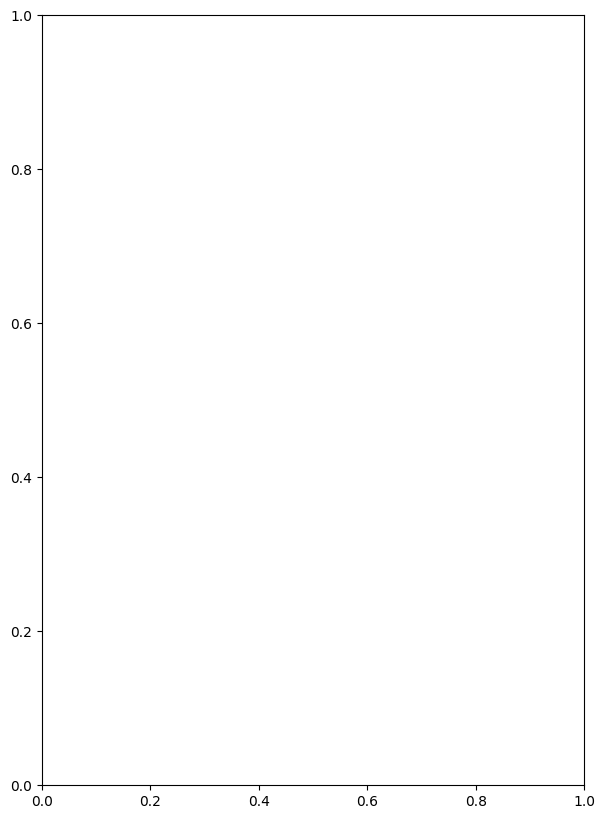

In [ ]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))

df = df_test_numeric[(df_test_numeric['latitud'] < -34) & (df_test_numeric['latitud'] > -35) & (df_test_numeric['longitud'] > -59)]

# Reemplazar este dataframe por el nuestro
# Aca solo tendriamos que cambiar lat y long para que usen los del dataframe
# Lo que hace aca es convertir latitude y longitude en puntos
gdf = gpd.GeoDataFrame(df.drop(['latitud', 'longitud'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(df.longitud, df.latitud)])
world = gpd.read_file('mapa_caba/mapa.shp')


base = world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', markersize=1, c=[color_map[label] for label in model_3.labels_])

plt.show()

### Guardado del modelo entrenado

Se procede a guardar el modelo que se ha entrenado para que pueda ser usado sin tener que re-entrenarlo posteriormente.

In [ ]:
# from joblib import dump, load
# dump(model, 'fitted_model.joblib')

# Usar model = load('fitted_model.joblib') para cargar el mismo.

NameError: name 'df_numeris_fitted' is not defined

to do: investigar lo de pipeline para hacer mismas transformaciones de training y test

# 3. Clasificación

## a) Construcción del target

Cargamos nuestro dataset reducido y crearemos una nueva columna 'pxm2' que sera el precio por metro cuadrado, que sera la columna que nos dira si una priopiedad tiene un tipo de precio alto, medio o bajo

In [ ]:
df_clasification = pd.read_csv("datasets/ds.csv")

df_clasification['pxm2'] = df_clasification['property_price'] / df_clasification['property_surface_total'] 
df_clasification.head(3)

Analizamos su distribucion

Distribucion de precio por metro cuadrado

In [ ]:
ax = sns.histplot(data=df_clasification, x=df_clasification['pxm2'])
ax.set(title="Grafico de distribucion de precio por metro cuadrado")

Distribucion de precio por metro cuadrado por tipo de propiedad

In [ ]:
ax = sns.histplot(data=df_clasification, x=df_clasification['pxm2'], hue='property_type')
ax.set(title="Distribucion de precio por metro cuadrado por tipo de propiedad")

Para saber los limites de cada categoria tenemos las siguientes alternativas

1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.
2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.
3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en
el punto anterior.

Declaramos los 3 tipos de precios

In [ ]:
tipos_de_precios = ['bajo', 'medio', 'alto']

In [ ]:
def frec_relativa(series):
  abs_frec = series.value_counts()
  return abs_frec / series.value_counts().sum()

### Alternativa 1

Separamos los valores de pxm2 en 3 intervalos con igual cantidad de observaciones usando `qcut`

In [ ]:
quantiles = pd.qcut(df['pxm2'], 3)
ax = sns.barplot(data=df, x=['bajo', 'medio', 'alto'], y=frec_relativa(quantiles))
ax.set(title='Distribucion de tipo_precio')

### Alternativa 2 

Separamos en 3 intervalos, el primero con 25% de las obs., el segundo con 50% y el tercero con 25%

In [ ]:
def graph_quantiles(df, title):
    quantiles = pd.qcut(df['pxm2'], [0, .25, .75, 1])
    ax = sns.barplot(data=df, x=tipos_de_precios, y=frec_relativa(quantiles).sort_index())
    ax.set(title=title)
    plt.show()

graph_quantiles(df, "Distribucion de precio por metro cuadrado")

### Alternativa 3

Lo mismo que la alternativa 2, pero relativo a cada tipo de propiedad (Casa, Departamento y PH)

In [ ]:
property_types = ['Casa', 'Departamento', 'PH']

for type in property_types:
  property_df = df[df['property_type'] == type]
  graph_quantiles(property_df, f"Distribucion de precio por metro cuadrado para {type}")
  

Seleccionaremos la tercera alternativa, esto es debido a que el precio por metro cuadrado entre cada tipo de propiedad puede ser alto o bajo dependiendo del mismo, el pmx2 de una casa vale mas que el de un PH y departamento. Utilizando las otras 2 alternativas, los avisos que tienen tipo_precio alto podrian corresponder a propiedades de tipo casa y los bajos a departamentos, al usar la tercera, podemos distribuir los tipos de precio considerando el tipo de propiedad, logrando una distribucion mas equitativa.

Agregamos la columna tipo_precio al dataframe

In [ ]:
property_types = ['Casa', 'Departamento', 'PH']
dfs = []

for type in property_types:
  property_df = df[df['property_type'] == type].copy()
  quantiles = pd.qcut(property_df['pxm2'], [0, .25, .75, 1], labels=tipos_de_precios)
  property_df.loc[:, 'tipo_precio'] = quantiles
  dfs.append(property_df)

df_with_tipo_precio = pd.concat(dfs)
df_with_tipo_precio
  

# b) Entrenamiento y Predicción

Para este punto se pide predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price,
pxm2 y cualquier otra que pueda contener información del precio de venta. Para ello, crearemos distintos modelos.

## Modelo 1 : Árbol de decisión

### a- Construir un árbol de decisión y optimizar sus hiperparámetros mediante k-fold
 Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
 ¿Qué métrica consideran adecuada para buscar los parámetros?

Randomized Search Cross Validation

¿Cómo buscar la mejor combinación de hiperparámetros?

Exploramos un espacio de búsqueda, usando k-fold CV para medir el desempeño de cada combinación. Al terminar, nos quedamos con la combinación con mejor desempeño y entrenamos un único modelo usando todos los datos de train.

- Random Search: explorar opciones y combinaciones al azar

- Grid Search: plantear opciones y explorar todas las combinaciones

Algunos hiperparámetros de los árboles de decisión:

- Criterio de elección de atributos en cada nodo (Information Gain, Gini Gain)


- Criterio de parada (ej: máxima profundidad)


- Estrategia de poda

Además, la métrica que consideramos adecuada para buscar los parámetros va a ser el f1_score

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero porbar
n=10 

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,6))}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparámetros que optimizan F1 Score
randomcv.fit(x_train,y_train);

Los mejores hiperparámetros que optimizan el F1 Score son:

In [ ]:
#Mejores hiperpárametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

In [ ]:
randomcv.cv_results_['mean_test_score']

In [ ]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

Predicción y Evaluación del Modelo con mejores hiperparámetros

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(features))
print(reglas)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93b86fc9-77e6-4ecc-8d2c-ef4e6ae5be5f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>